In [4]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


In [5]:
import DarkVerse as dv
%matplotlib inline
plt.rc('font',**{'family':'serif','size':14})
#plt.rc('text', usetex=True)


In [6]:
home_dir = os.path.expanduser('~')
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 
res = os.path.join(home_dir, 'Master_Thesis', 'Results')

# Now trying all my fields 

### SM Completeness (for COMSMOS)
\begin{array}{c|c}
\textbf{Redshift Range}~(z) & \textbf{Mass Limit}~\log_{10}(M_*/M_\odot) \\
\hline
0.1 & 7.44 \\
0.2 & 7.87 \\
0.3 & 8.23 \\
0.4 & 8.41 \\
0.5  & 8.61 \\
0.6 & 8.85 \\
0.7 & 9.09 \\
0.8 & 9.41 \\
0.9 & 9.63 \\
1.0 & 9.76 \\
\end{array}


<>:143: SyntaxWarning: invalid escape sequence '\i'
<>:143: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_1856111/2126814310.py:143: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_*$, $z \in [{z_min},{z_max}]$', fontsize=14)




🔹 Processing stellar mass bin 9.5–10.5

🔸 Processing field: SN-X3
HOD fit results: M_min = 10^11.38, M_1 = 10^12.53, alpha = 0.63


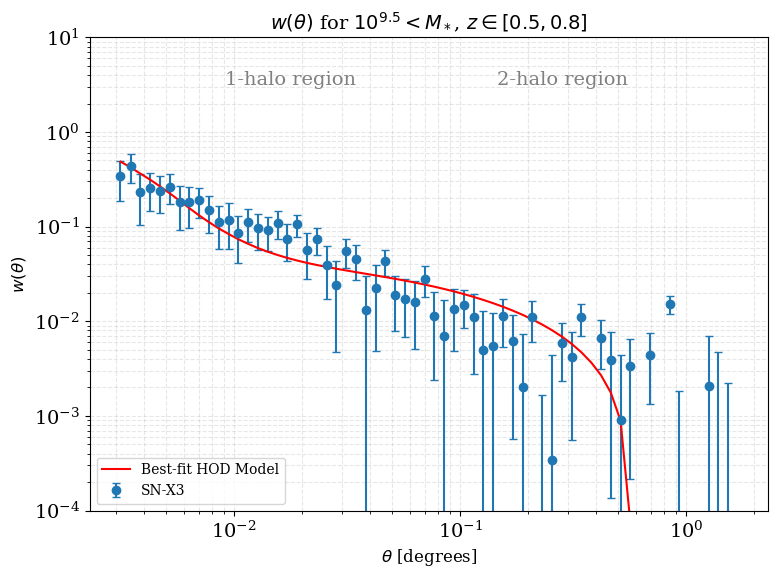

  ➤ bias_eff = 1.130

🔸 Processing field: SN-C3
HOD fit results: M_min = 10^12.39, M_1 = 10^13.95, alpha = 1.91


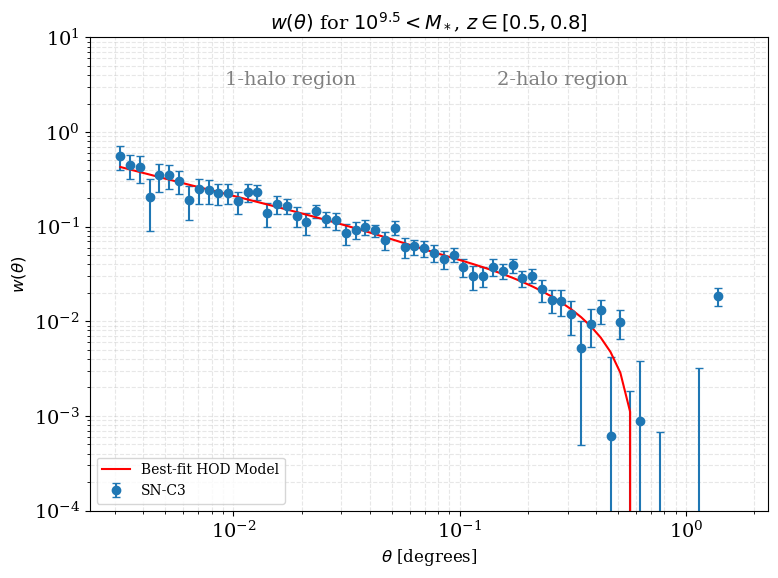

  ➤ bias_eff = 1.646

🔸 Processing field: SN-E2
HOD fit results: M_min = 10^11.00, M_1 = 10^12.99, alpha = 1.60


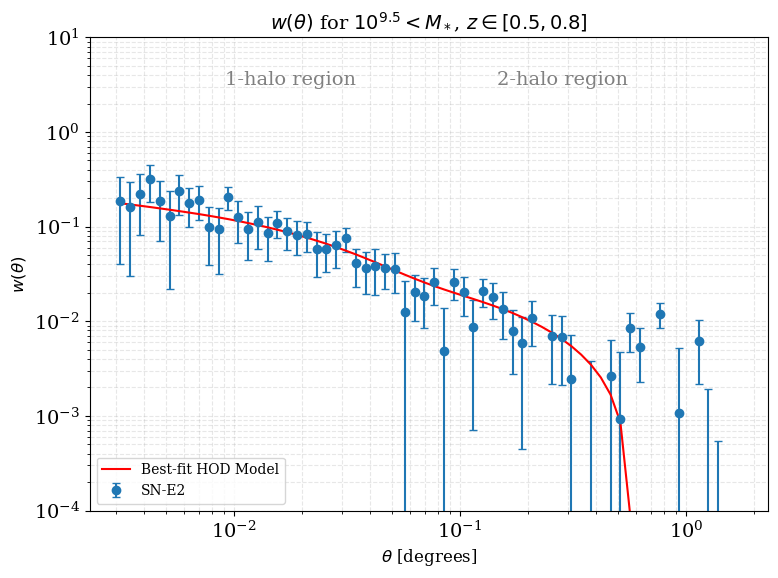

  ➤ bias_eff = 1.098

🔸 Processing field: COSMOS
HOD fit results: M_min = 10^12.36, M_1 = 10^14.01, alpha = 2.00


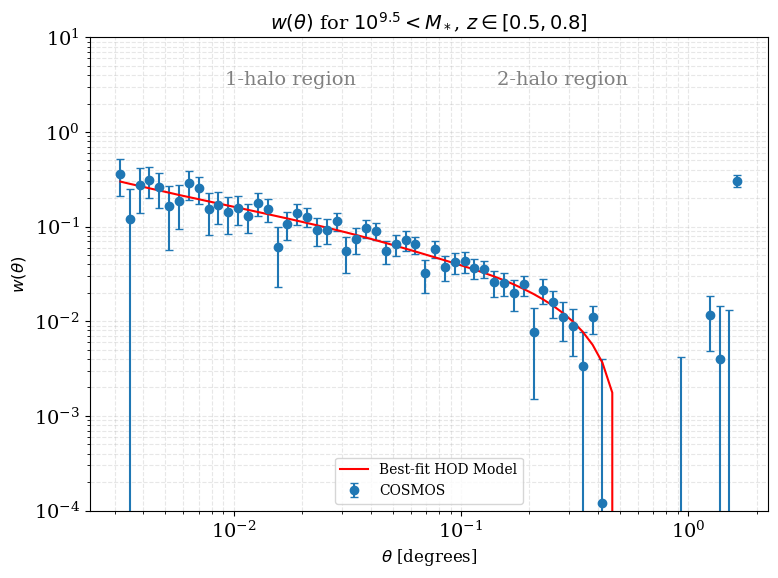

  ➤ bias_eff = 1.601

Individual Field Results:
SN-X3: b = 1.273 ± 0.052, IC = 0.0078
SN-C3: b = 1.700 ± 0.029, IC = 0.0126
SN-E2: b = 1.304 ± 0.038, IC = 0.0079
COSMOS: b = 1.699 ± 0.032, IC = 0.0159

Global bias estimate: 1.351 ± 0.016


🔹 Processing stellar mass bin 10.5–12.5

🔸 Processing field: SN-X3
HOD fit results: M_min = 10^11.45, M_1 = 10^12.50, alpha = 0.87


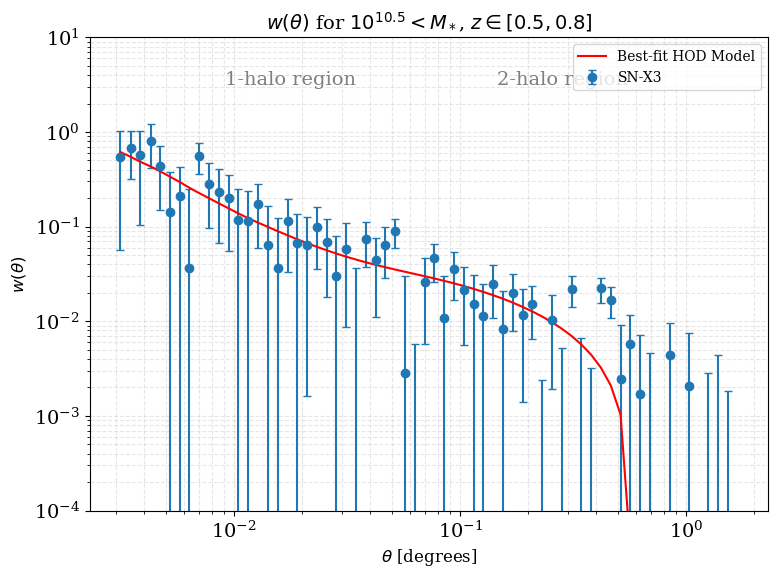

  ➤ bias_eff = 1.244

🔸 Processing field: SN-C3
HOD fit results: M_min = 10^12.78, M_1 = 10^14.13, alpha = 1.90


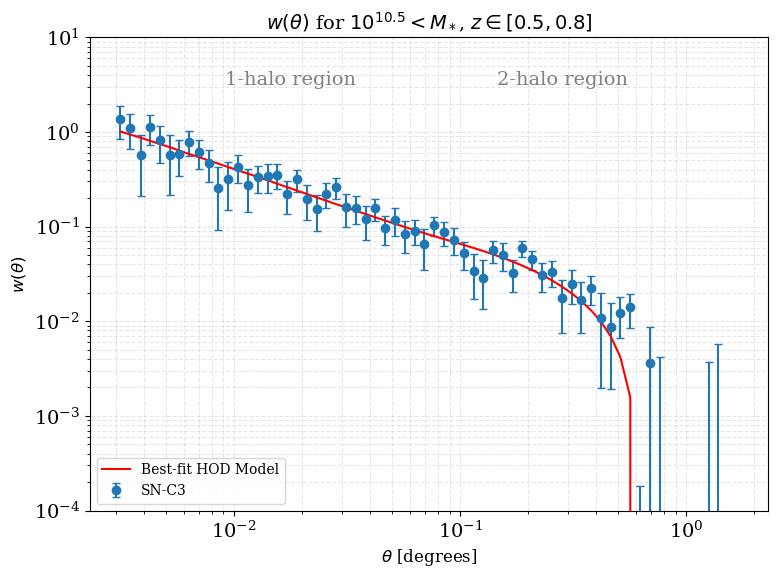

  ➤ bias_eff = 1.998

🔸 Processing field: SN-E2
HOD fit results: M_min = 10^11.93, M_1 = 10^13.33, alpha = 1.30


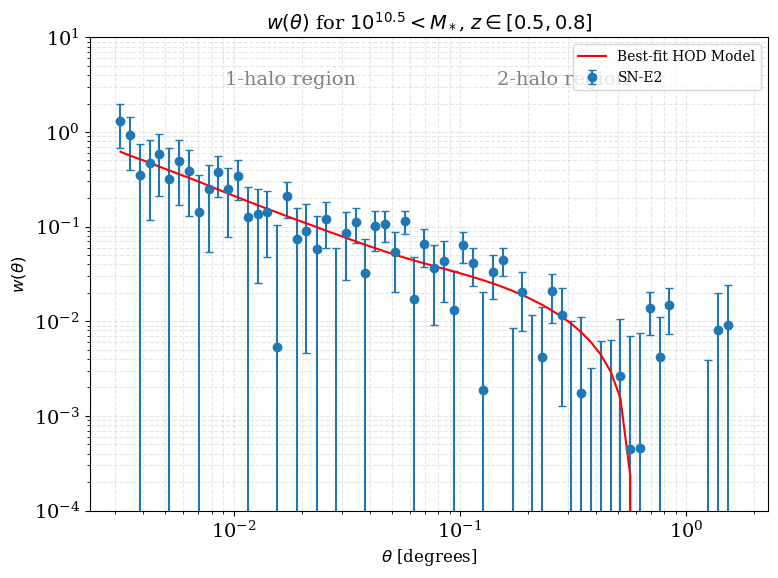

  ➤ bias_eff = 1.434

🔸 Processing field: COSMOS
HOD fit results: M_min = 10^12.19, M_1 = 10^13.66, alpha = 1.46


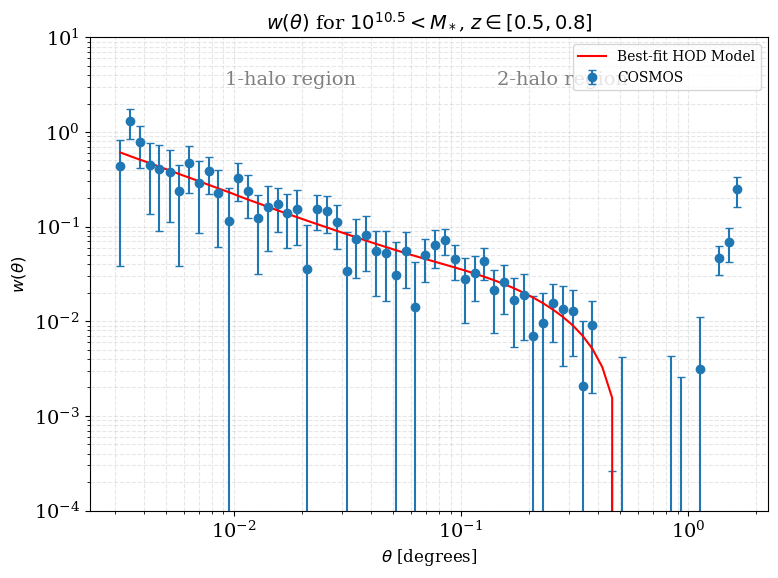

  ➤ bias_eff = 1.543

Individual Field Results:
SN-X3: b = 1.386 ± 0.071, IC = 0.0092
SN-C3: b = 1.940 ± 0.060, IC = 0.0165
SN-E2: b = 1.487 ± 0.094, IC = 0.0103
COSMOS: b = 1.643 ± 0.040, IC = 0.0148

Global bias estimate: 1.531 ± 0.036


In [17]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

stellar_masses = []
halo_masses = []

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78, 
    #'nbins': 10,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}

# Fixed redshift range
z_min, z_max = 0.5, 0.8


# Define stellar mass bins
#SM_bins = [(8.17, 8.6), (8.6, 9.0), (9.0, 9.6), (9.6, 10.5), (10.5, 12.5)]
#SM_bins = [(10.5, 12.5)]
#SM_bins = [ (8, 9), (9, 10), (10, 11), (11, 12.5)]

SM_bins = [ (9.5, 10.5), (10.5, 12.5)]


#colors = ["blue", "green", "red", "purple", "orange"]
colors = {
    "SN-C3": "tab:blue",
    "SN-X3": "tab:orange",
    "COSMOS": "tab:red",
    "SN-E2": "tab:green"
}

# Initialize storage
all_results = {sm_range: {} for sm_range in SM_bins}

# Process each stellar mass bin
for SM_min, SM_max in SM_bins:
    print(f"\n\n🔹 Processing stellar mass bin {SM_min}–{SM_max}")
    
    # Initialize bias estimator with the first field
    first_field = list(fields.keys())[0]
    first_catalog = Table.read(os.path.join(thesis_path, fields[first_field]["catalog"]))
    first_masked = Table.read(os.path.join(thesis_path, fields[first_field]["masked"]))
    first_catalog = join(first_catalog, first_masked, keys='id')
    first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    first_randoms = Table.read(os.path.join(thesis_path, fields[first_field]["randoms"]))
    
    first_subsample = dv.Selection(
        catalog=first_catalog,
        randoms=first_randoms,
        z_min=z_min,
        z_max=z_max,
        SM_min=SM_min,
        SM_max=SM_max,
        config=config
    )
    first_results = first_subsample.get_results()
    
    estimator = dv.FieldBiasEstimator(
        xi_m=np.array(first_results['xi_m']),
        mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
    )
    
    bias_eff_dict = {}

    # Process all fields
    for field, paths in fields.items():
        print(f"\n🔸 Processing field: {field}")
        
        catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
        masked = Table.read(os.path.join(thesis_path, paths["masked"]))
        catalog = join(catalog, masked, keys='id') # Join masked and catalog
        catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))
        
        subsample = dv.Selection(
            catalog=catalog,
            randoms=randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )

        #hod_params, pcov, pdict = subsample.fit_hod()
        #print(f"  ➤ fit diagnostics: {pdict['message']} (success={pdict['success']}, nfev={pdict['nfev']})")
        
        # HOD fitting for this stellar mass bin        
        hod_params, pcov = subsample.fit_hod()
        
        results = subsample.get_results()
        theta = results['theta']
        w_theta = results['w_theta']
        w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap']))

        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.errorbar(theta, w_theta, yerr=w_theta_error, fmt='o', label= field, capsize=3)

        
        logM_min, logM_1, alpha = results['hod_params']
        print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
              f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")
        
        w_model = subsample.hod_model(logM_min *1e7, logM_1, alpha) 
        ax.plot(theta, w_model, label='Best-fit HOD Model', color='red')
        
        xi_m_values = subsample.get_results()['xi_m']
        # ax.plot(theta, xi_m_values, label=r'$\omega_{dm}(\theta)$ (Matter)', linestyle='dashed', color='black')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
        ax.set_ylabel(r'$w(\theta)$', fontsize=12)
        ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_*$, $z \in [{z_min},{z_max}]$', fontsize=14)
    
        ax.set_ylim([1e-4, 10])
        ax.legend(fontsize=10, framealpha=0.8)
        ax.grid(True, which="both", ls="--", alpha=0.3)
    
        # Optional annotations
        ax.text(0.2, 0.9, "1-halo region", transform=ax.transAxes, color='gray')
        ax.text(0.6, 0.9, "2-halo region", transform=ax.transAxes, color='gray')
    
        plt.tight_layout()
        #plt.savefig(f"wtheta_{field}_HOD_SM_{SM_min}_{SM_max}.png")
        plt.show()


        
        bias_eff = subsample.gg.bias_effective_tracer
        bias_eff_dict[field] = bias_eff
        print(f"  ➤ bias_eff = {bias_eff:.3f}")


        
        estimator.add_field(
            field_name=field,
            xi_g=np.array(results['xi_g']),
            w_theta=np.array(results['w_theta']),
            w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),
            sum_rr=np.array(results['rr_counts'])
        )
        
        # Compute stellar-to-halo mass ratio
        logM_star = SM_min  # log stellar mass threshold
        logM_halo = logM_min *1e7  # From HOD fit
        M_star = 10**logM_star
        M_halo = 10**logM_halo
        stellar_masses.append(M_star)
        halo_masses.append(M_halo)
        


    
    print("\nIndividual Field Results:")
    individual_results = estimator.fit_individual_fields()
    for name, b, be, ic in individual_results:
        print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")
    
    global_b, global_be = estimator.fit_combined()
    print(f"\nGlobal bias estimate: {global_b:.3f} ± {global_be:.3f}")
    
    all_results[(SM_min, SM_max)] = {
        'individual': individual_results,
        'global_b': global_b,
        'global_be': global_be,
        'estimator': estimator,
        'bias_eff': bias_eff_dict,
        'logM_min': logM_min 
    }



    

In [59]:
""" fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.errorbar(X, w[:len(X)], yerr=std_dev[:len(X)], fmt='o', label='SN-C3')
#ax.plot(X, w_t(A_median, power_median, X, mask_rr),'k:')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_title('2PCF with with std from bootstrap' )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
#ax.set_xlim([8e-4,2.])
secax = ax.secondary_xaxis('top',functions=(lambda x: x*Planck15.kpc_proper_per_arcmin(z_mean).value*60./1e3,
                                   lambda x: x*Planck15.arcsec_per_kpc_proper(z_mean).value*1e3/3.6e3))
secax.set_xlabel(r'Mpc')
ax.legend()
plt.savefig("bootstrap.png")
plt.show()"""

' fig = plt.figure(figsize=[10,7])\nax = fig.add_subplot(111)\nax.errorbar(X, w[:len(X)], yerr=std_dev[:len(X)], fmt=\'o\', label=\'SN-C3\')\n#ax.plot(X, w_t(A_median, power_median, X, mask_rr),\'k:\')\nax.set_xlabel(r\'$\theta$ (degrees)\')\nax.set_ylabel(r\'$w(\theta)$\')\nax.set_title(\'2PCF with with std from bootstrap\' )\n\nax.set_xscale(\'log\')\nax.set_yscale(\'log\')\nax.set_ylim([1e-4,10.])\n#ax.set_xlim([8e-4,2.])\nsecax = ax.secondary_xaxis(\'top\',functions=(lambda x: x*Planck15.kpc_proper_per_arcmin(z_mean).value*60./1e3,\n                                   lambda x: x*Planck15.arcsec_per_kpc_proper(z_mean).value*1e3/3.6e3))\nsecax.set_xlabel(r\'Mpc\')\nax.legend()\nplt.savefig("bootstrap.png")\nplt.show()'

<>:143: SyntaxWarning: invalid escape sequence '\i'
<>:143: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_1856111/441895585.py:143: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_*$, $z \in [{z_min},{z_max}]$', fontsize=14)




🔹 Processing stellar mass bin 8.6–9
The following patch numbers have no objects: {30}
This may be a problem depending on your use case.

🔸 Processing field: SN-X3
The following patch numbers have no objects: {29}
This may be a problem depending on your use case.
HOD fit results: M_min = 10^11.04, M_1 = 10^12.98, alpha = 0.47


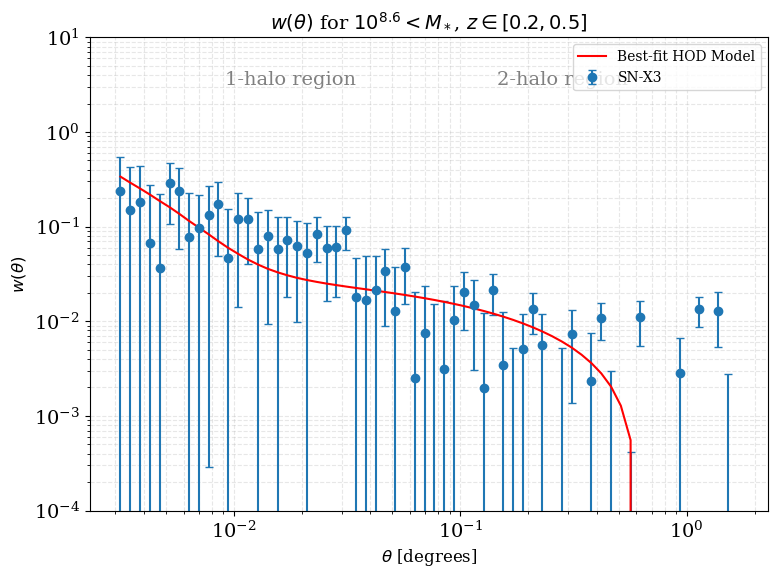

  ➤ bias_eff = 0.870

🔸 Processing field: SN-C3
HOD fit results: M_min = 10^11.23, M_1 = 10^13.38, alpha = 1.67


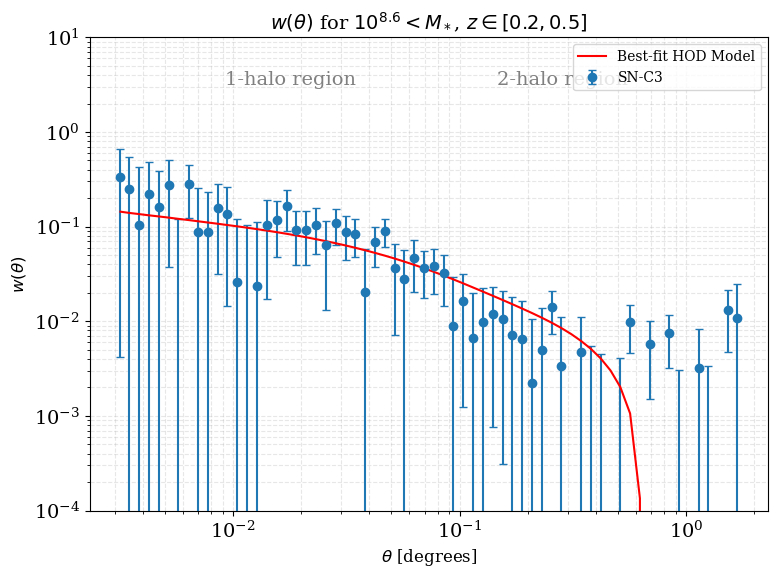

  ➤ bias_eff = 1.003

🔸 Processing field: SN-E2
HOD fit results: M_min = 10^11.98, M_1 = 10^15.50, alpha = 1.99


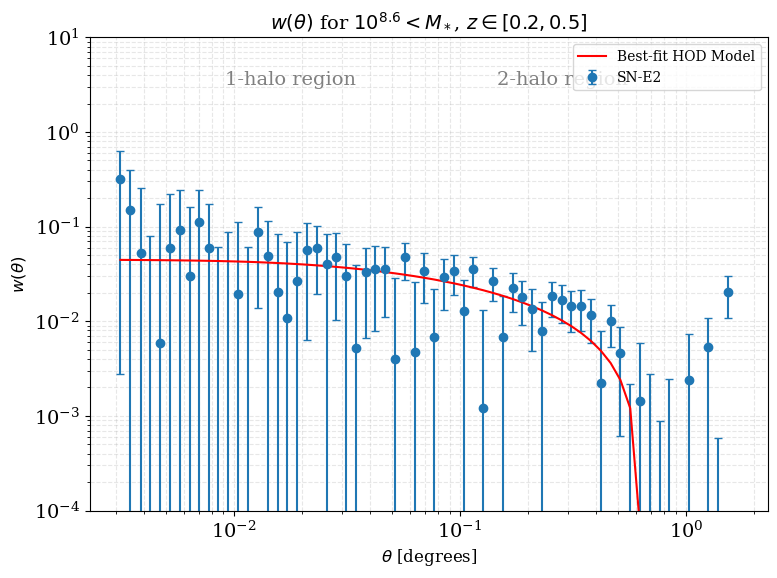

  ➤ bias_eff = 1.102

🔸 Processing field: COSMOS
HOD fit results: M_min = 10^11.00, M_1 = 10^12.94, alpha = 1.00


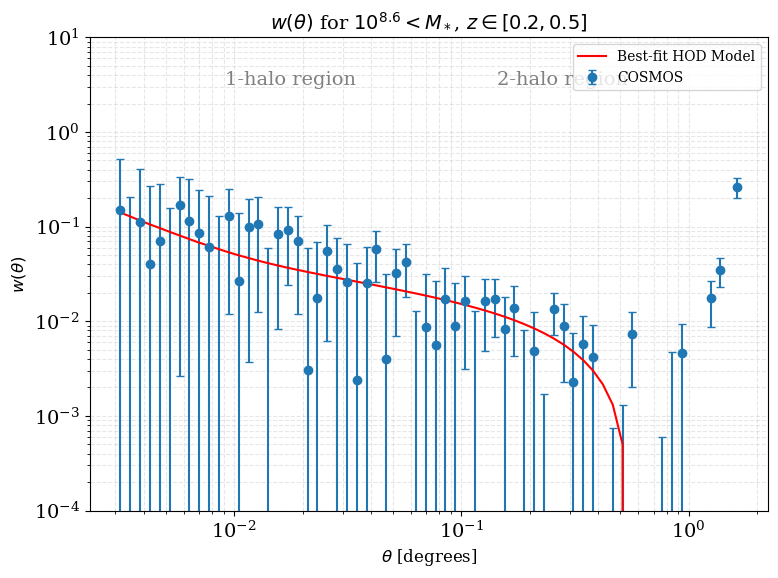

  ➤ bias_eff = 0.902

Individual Field Results:
SN-X3: b = 1.171 ± 0.040, IC = 0.0136
SN-C3: b = 1.164 ± 0.034, IC = 0.0126
SN-E2: b = 1.371 ± 0.048, IC = 0.0183
COSMOS: b = 1.300 ± 0.043, IC = 0.0188

Global bias estimate: 1.056 ± 0.022


🔹 Processing stellar mass bin 9–10

🔸 Processing field: SN-X3
HOD fit results: M_min = 10^11.13, M_1 = 10^12.50, alpha = 0.89


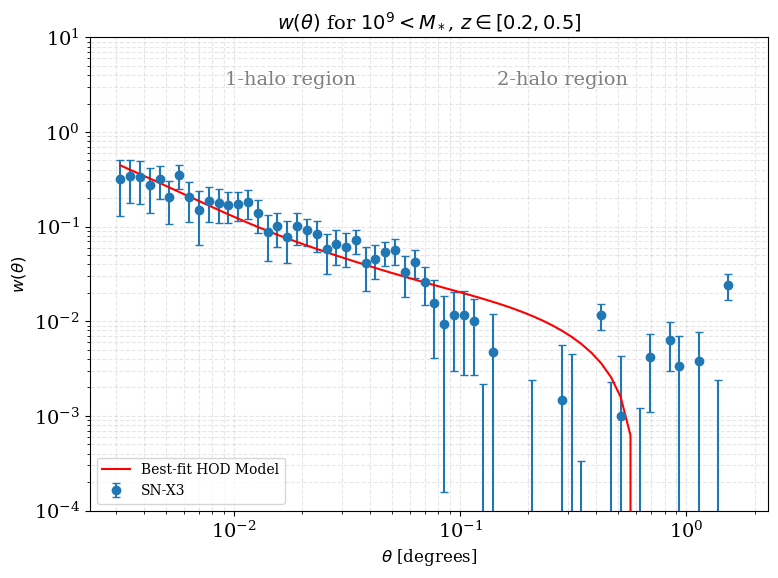

  ➤ bias_eff = 0.997

🔸 Processing field: SN-C3
HOD fit results: M_min = 10^11.35, M_1 = 10^12.51, alpha = 0.61


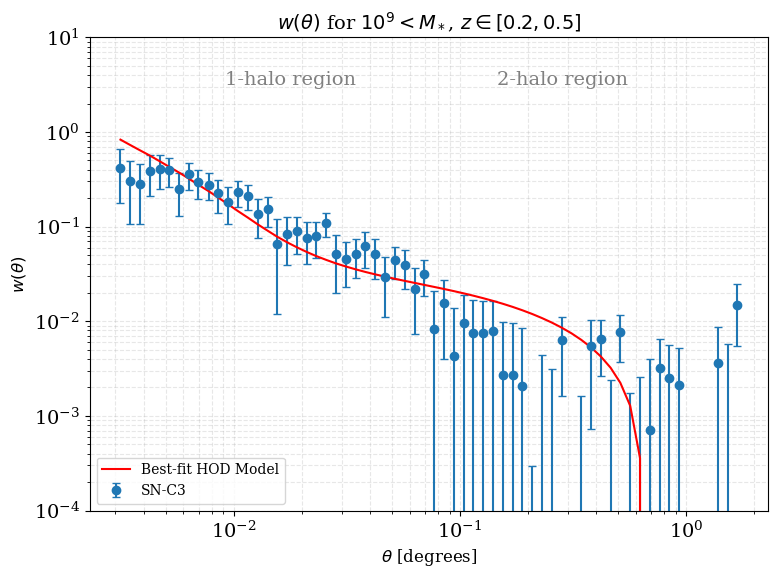

  ➤ bias_eff = 0.991

🔸 Processing field: SN-E2
HOD fit results: M_min = 10^12.21, M_1 = 10^13.99, alpha = 1.61


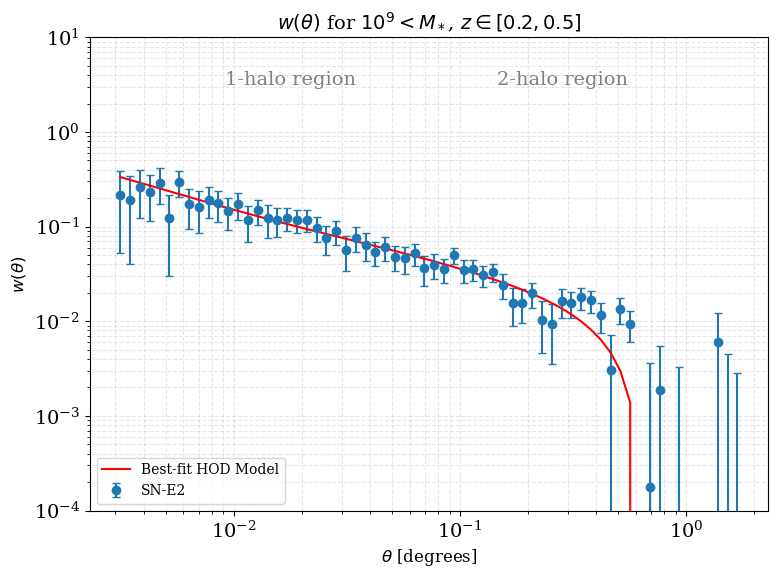

  ➤ bias_eff = 1.280

🔸 Processing field: COSMOS
HOD fit results: M_min = 10^11.17, M_1 = 10^12.82, alpha = 1.16


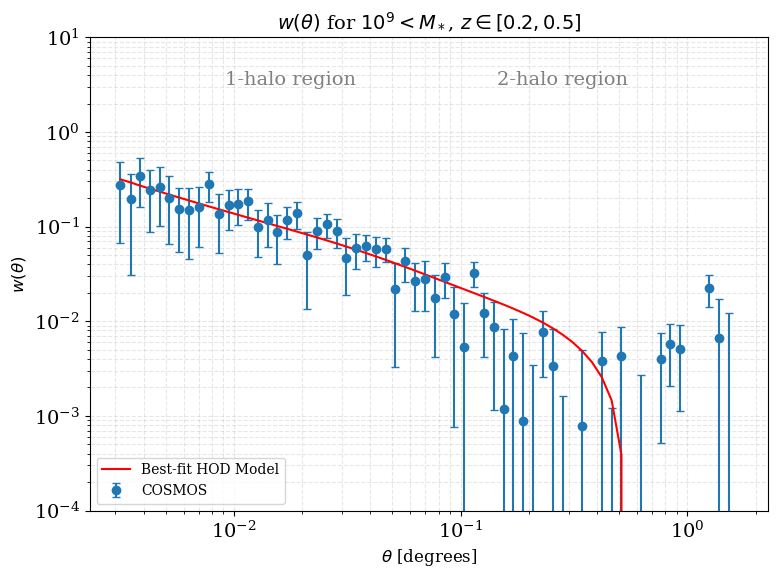

  ➤ bias_eff = 1.034

Individual Field Results:
SN-X3: b = 1.011 ± 0.039, IC = 0.0102
SN-C3: b = 1.056 ± 0.041, IC = 0.0103
SN-E2: b = 1.431 ± 0.034, IC = 0.0199
COSMOS: b = 1.196 ± 0.031, IC = 0.0159

Global bias estimate: 0.928 ± 0.024


🔹 Processing stellar mass bin 10–11
The following patch numbers have no objects: {30}
This may be a problem depending on your use case.
The following patch numbers have no objects: {28}
This may be a problem depending on your use case.

🔸 Processing field: SN-X3
HOD fit results: M_min = 10^11.39, M_1 = 10^12.52, alpha = 0.77


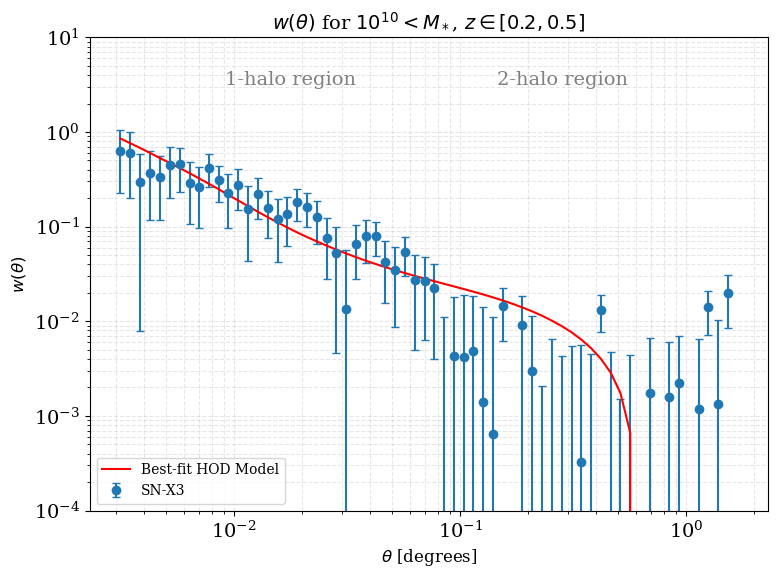

  ➤ bias_eff = 1.051

🔸 Processing field: SN-C3
HOD fit results: M_min = 10^11.93, M_1 = 10^13.59, alpha = 0.84


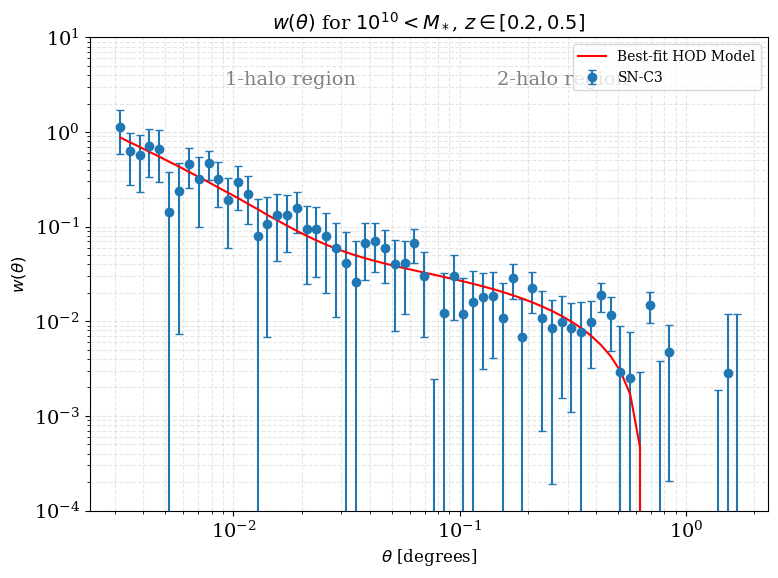

  ➤ bias_eff = 1.149

🔸 Processing field: SN-E2
HOD fit results: M_min = 10^12.76, M_1 = 10^14.32, alpha = 1.71


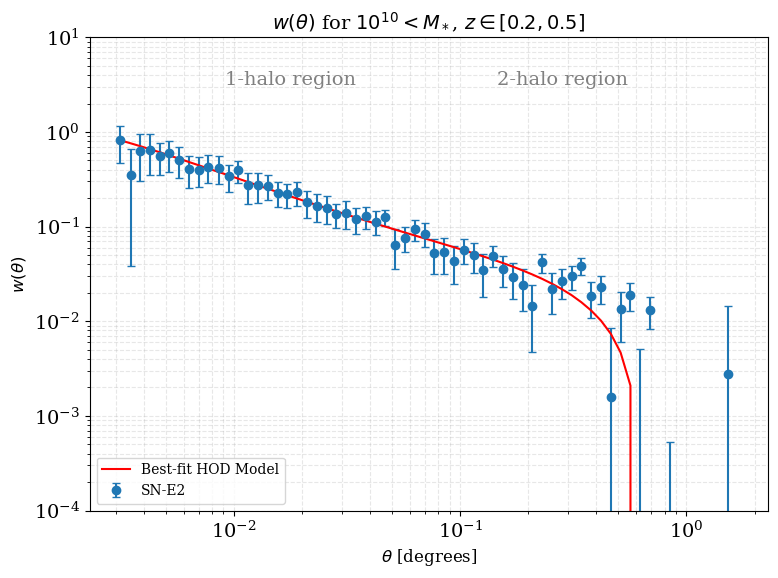

  ➤ bias_eff = 1.617

🔸 Processing field: COSMOS
HOD fit results: M_min = 10^11.01, M_1 = 10^12.61, alpha = 1.07


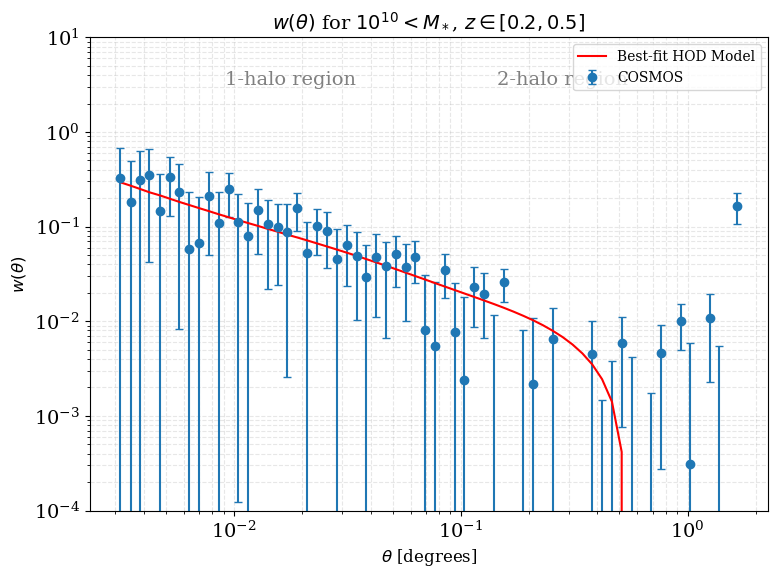

  ➤ bias_eff = 0.998

Individual Field Results:
SN-X3: b = 1.097 ± 0.040, IC = 0.0119
SN-C3: b = 1.307 ± 0.038, IC = 0.0158
SN-E2: b = 1.629 ± 0.050, IC = 0.0258
COSMOS: b = 1.160 ± 0.057, IC = 0.0149

Global bias estimate: 1.107 ± 0.024


🔹 Processing stellar mass bin 11–12.5
The following patch numbers have no objects: {37}
This may be a problem depending on your use case.
The following patch numbers have no objects: {17}
This may be a problem depending on your use case.
The following patch numbers have no objects: {31}
This may be a problem depending on your use case.
The following patch numbers have no objects: {17}
This may be a problem depending on your use case.
The following patch numbers have no objects: {22}
This may be a problem depending on your use case.
The following patch numbers have no objects: {21}
This may be a problem depending on your use case.
The following patch numbers have no objects: {25}
This may be a problem depending on your use case.
The following patch nu

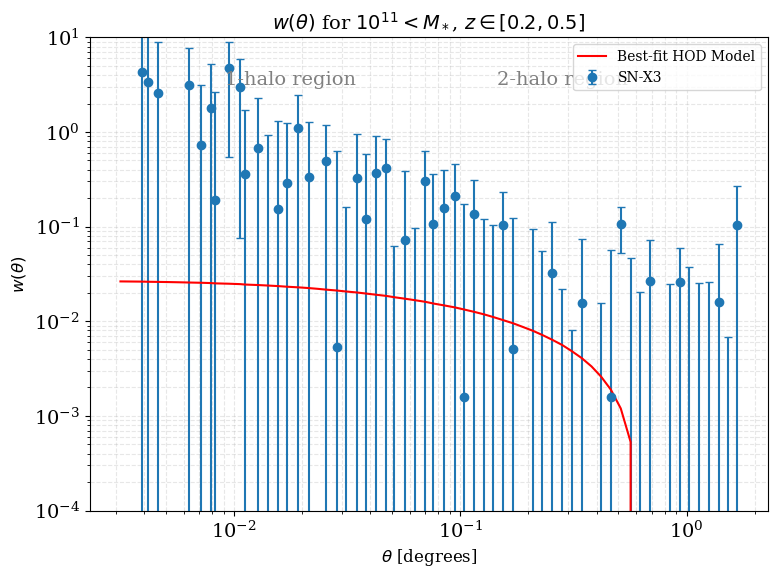

  ➤ bias_eff = 0.836

🔸 Processing field: SN-C3
The following patch numbers have no objects: {36}
This may be a problem depending on your use case.
The following patch numbers have no objects: {17, 23}
This may be a problem depending on your use case.
The following patch numbers have no objects: {17, 19, 29, 31}
This may be a problem depending on your use case.
The following patch numbers have no objects: {12}
This may be a problem depending on your use case.
The following patch numbers have no objects: {36}
This may be a problem depending on your use case.
The following patch numbers have no objects: {16, 36}
This may be a problem depending on your use case.
The following patch numbers have no objects: {21}
This may be a problem depending on your use case.
The following patch numbers have no objects: {20}
This may be a problem depending on your use case.
The following patch numbers have no objects: {6}
This may be a problem depending on your use case.
The following patch numbers have 

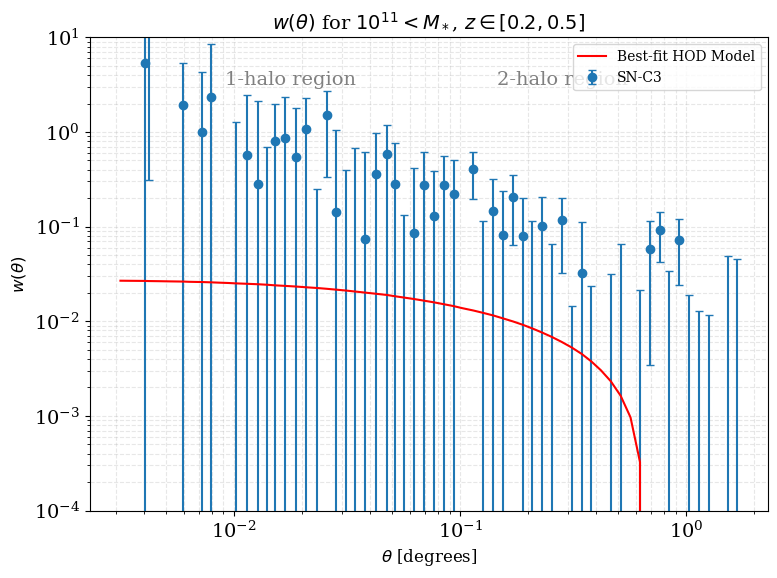

  ➤ bias_eff = 0.836

🔸 Processing field: SN-E2
The following patch numbers have no objects: {10}
This may be a problem depending on your use case.
The following patch numbers have no objects: {26}
This may be a problem depending on your use case.
The following patch numbers have no objects: {8}
This may be a problem depending on your use case.
The following patch numbers have no objects: {8}
This may be a problem depending on your use case.
The following patch numbers have no objects: {9}
This may be a problem depending on your use case.
The following patch numbers have no objects: {42}
This may be a problem depending on your use case.
The following patch numbers have no objects: {27}
This may be a problem depending on your use case.
The following patch numbers have no objects: {5}
This may be a problem depending on your use case.
The following patch numbers have no objects: {27}
This may be a problem depending on your use case.
The following patch numbers have no objects: {23}
This m

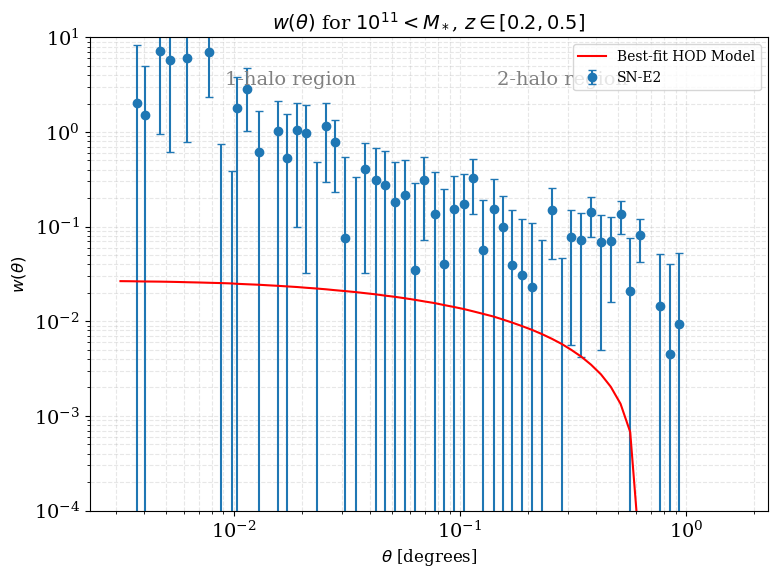

  ➤ bias_eff = 0.836

🔸 Processing field: COSMOS
The following patch numbers have no objects: {10}
This may be a problem depending on your use case.
The following patch numbers have no objects: {11}
This may be a problem depending on your use case.
The following patch numbers have no objects: {3}
This may be a problem depending on your use case.
The following patch numbers have no objects: {9}
This may be a problem depending on your use case.
The following patch numbers have no objects: {28}
This may be a problem depending on your use case.
The following patch numbers have no objects: {37}
This may be a problem depending on your use case.
The following patch numbers have no objects: {35}
This may be a problem depending on your use case.
The following patch numbers have no objects: {8, 29}
This may be a problem depending on your use case.
The following patch numbers have no objects: {29}
This may be a problem depending on your use case.
The following patch numbers have no objects: {37}


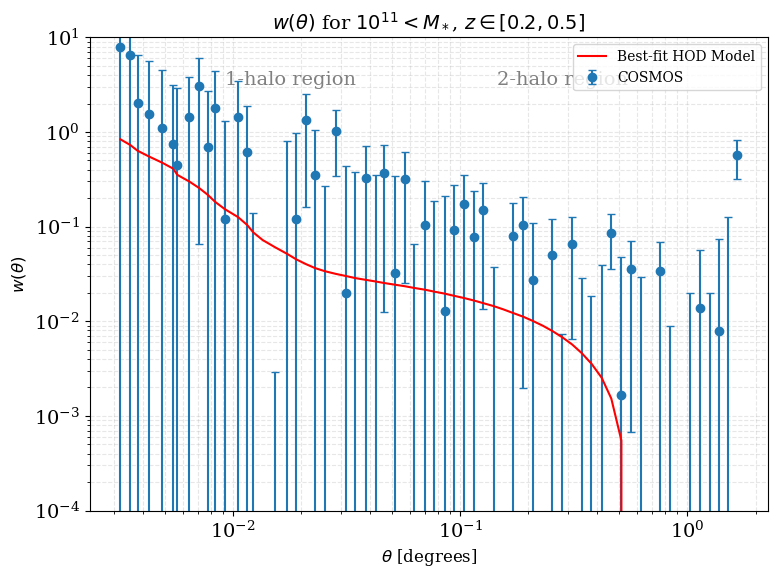

  ➤ bias_eff = 0.987

Individual Field Results:
SN-X3: b = 0.121 ± 3.354, IC = 0.0001
SN-C3: b = 1.601 ± 0.476, IC = 0.0237
SN-E2: b = 2.135 ± 0.224, IC = 0.0444
COSMOS: b = 1.159 ± 0.453, IC = 0.0149

Global bias estimate: 1.326 ± 0.176


In [22]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

stellar_masses = []
halo_masses = []

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78, 
    #'nbins': 10,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}

# Fixed redshift range
z_min, z_max = 0.2, 0.5


# Define stellar mass bins
SM_bins = [ (8.6, 9), (9, 10), (10, 11), (11, 12.5)]


#colors = ["blue", "green", "red", "purple", "orange"]
colors = {
    "SN-C3": "tab:blue",
    "SN-X3": "tab:orange",
    "COSMOS": "tab:red",
    "SN-E2": "tab:green"
}

# Initialize storage
all_results = {sm_range: {} for sm_range in SM_bins}

# Process each stellar mass bin
for SM_min, SM_max in SM_bins:
    print(f"\n\n🔹 Processing stellar mass bin {SM_min}–{SM_max}")
    
    # Initialize bias estimator with the first field
    first_field = list(fields.keys())[0]
    first_catalog = Table.read(os.path.join(thesis_path, fields[first_field]["catalog"]))
    first_masked = Table.read(os.path.join(thesis_path, fields[first_field]["masked"]))
    first_catalog = join(first_catalog, first_masked, keys='id')
    first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    first_randoms = Table.read(os.path.join(thesis_path, fields[first_field]["randoms"]))
    
    first_subsample = dv.Selection(
        catalog=first_catalog,
        randoms=first_randoms,
        z_min=z_min,
        z_max=z_max,
        SM_min=SM_min,
        SM_max=SM_max,
        config=config
    )
    first_results = first_subsample.get_results()
    
    estimator = dv.FieldBiasEstimator(
        xi_m=np.array(first_results['xi_m']),
        mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
    )
    
    bias_eff_dict = {}

    # Process all fields
    for field, paths in fields.items():
        print(f"\n🔸 Processing field: {field}")
        
        catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
        masked = Table.read(os.path.join(thesis_path, paths["masked"]))
        catalog = join(catalog, masked, keys='id') # Join masked and catalog
        catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))
        
        subsample = dv.Selection(
            catalog=catalog,
            randoms=randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )

        #hod_params, pcov, pdict = subsample.fit_hod()
        #print(f"  ➤ fit diagnostics: {pdict['message']} (success={pdict['success']}, nfev={pdict['nfev']})")
        
        # HOD fitting for this stellar mass bin        
        hod_params, pcov = subsample.fit_hod()
        
        results = subsample.get_results()
        theta = results['theta']
        w_theta = results['w_theta']
        w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap']))

        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.errorbar(theta, w_theta, yerr=w_theta_error, fmt='o', label= field, capsize=3)

        
        logM_min, logM_1, alpha = results['hod_params']
        print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
              f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")
        
        w_model = subsample.hod_model(logM_min *1e7, logM_1, alpha) 
        ax.plot(theta, w_model, label='Best-fit HOD Model', color='red')
        
        xi_m_values = subsample.get_results()['xi_m']
        # ax.plot(theta, xi_m_values, label=r'$\omega_{dm}(\theta)$ (Matter)', linestyle='dashed', color='black')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
        ax.set_ylabel(r'$w(\theta)$', fontsize=12)
        ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_*$, $z \in [{z_min},{z_max}]$', fontsize=14)
    
        ax.set_ylim([1e-4, 10])
        ax.legend(fontsize=10, framealpha=0.8)
        ax.grid(True, which="both", ls="--", alpha=0.3)
    
        # Optional annotations
        ax.text(0.2, 0.9, "1-halo region", transform=ax.transAxes, color='gray')
        ax.text(0.6, 0.9, "2-halo region", transform=ax.transAxes, color='gray')
    
        plt.tight_layout()
        #plt.savefig(f"wtheta_{field}_HOD_SM_{SM_min}_{SM_max}.png")
        plt.show()


        
        bias_eff = subsample.gg.bias_effective_tracer
        bias_eff_dict[field] = bias_eff
        print(f"  ➤ bias_eff = {bias_eff:.3f}")


        
        estimator.add_field(
            field_name=field,
            xi_g=np.array(results['xi_g']),
            w_theta=np.array(results['w_theta']),
            w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),
            sum_rr=np.array(results['rr_counts'])
        )
        
        # Compute stellar-to-halo mass ratio
        logM_star = SM_min  # log stellar mass threshold
        logM_halo = logM_min *1e7  # From HOD fit
        M_star = 10**logM_star
        M_halo = 10**logM_halo
        stellar_masses.append(M_star)
        halo_masses.append(M_halo)
        


    
    print("\nIndividual Field Results:")
    individual_results = estimator.fit_individual_fields()
    for name, b, be, ic in individual_results:
        print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")
    
    global_b, global_be = estimator.fit_combined()
    print(f"\nGlobal bias estimate: {global_b:.3f} ± {global_be:.3f}")
    
    all_results[(SM_min, SM_max)] = {
        'individual': individual_results,
        'global_b': global_b,
        'global_be': global_be,
        'estimator': estimator,
        'bias_eff': bias_eff_dict,
        'logM_min': logM_min 
    }




In [95]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked":  "SN-X3_masked_cat.fits",
        "randoms":"SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked":  "SN-C3_masked_cat.fits",
        "randoms":"SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked":  "SN-E2_masked_cat.fits",
        "randoms":"SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked":  "COSMOS_masked_cat.fits",
        "randoms":"COSMOS_randoms_ugriz_trim_video.fits"
    }
}

# Plotting colors by field
colors = {
    "SN-C3":  "tab:blue",
    "SN-X3":  "tab:orange",
    "COSMOS": "tab:red",
    "SN-E2":  "tab:green"
}

# Configuration for dv.Selection
config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

# Redshift range
z_min, z_max = 0.2, 0.5

# Stellar mass bins (log M_*)
SM_bins = [(8.5, 9.0), (9.0, 9.5), (9.5,10.0), (10.0,10.5), (10.5, 11.0), (11.0, 12.5)]


sm_by_field   = {field: [] for field in fields.keys()}
halo_by_field = {field: [] for field in fields.keys()}

all_results = {sm_range: {} for sm_range in SM_bins}

# Loop over each stellar mass bin
for SM_min, SM_max in SM_bins:
    print(f"\n\n🔹 Processing stellar mass bin {SM_min}–{SM_max}")
    
    # Initialize bias estimator using the first field in the dictionary
    first_field = list(fields.keys())[0]
    first_paths = fields[first_field]
    first_catalog = Table.read(os.path.join(thesis_path, first_paths["catalog"]))
    first_masked = Table.read(os.path.join(thesis_path, first_paths["masked"]))
    first_catalog = join(first_catalog, first_masked, keys='id')
    first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    first_randoms = Table.read(os.path.join(thesis_path, first_paths["randoms"]))
    
    first_subsample = dv.Selection(
        catalog=first_catalog,
        randoms=first_randoms,
        z_min=z_min,
        z_max=z_max,
        SM_min=SM_min,
        SM_max=SM_max,
        config=config
    )
    first_results = first_subsample.get_results()
    
    # We choose a range of theta to fit the bias (for example 0.1–0.4 deg)
    estimator = dv.FieldBiasEstimator(
        xi_m=np.array(first_results['xi_m']),
        mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
    )
    
    bias_eff_dict = {}

    for field, paths in fields.items():
        print(f"\n🔸 Processing field: {field}")
        
        catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
        masked  = Table.read(os.path.join(thesis_path, paths["masked"]))
        catalog = join(catalog, masked, keys='id')
        catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))
        
        subsample = dv.Selection(
            catalog=catalog,
            randoms=randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )
        
        # Fit HOD for this bin + this field
        #hod_params, pcov = subsample.fit_hod()
        hod_params, pcov = sub1.fit_hod(p0=[12.59*1e-7, 13.97, 1.], bounds=([11.0*1e-7, 13., 0.99], [14.5*1e-7, 15.5, 1.01])) # Fix alpha to 1

        results = subsample.get_results()
        
        # Extract the best-fit log(M_min), log(M_1), alpha
        logM_min, logM_1, alpha = results['hod_params']
        logM_halo = logM_min * 1e7
        M_halo = 10**(logM_halo)
        M_SM = 10**(SM_min)
        
        # Append to our collection dictionaries:
        sm_by_field[field].append(M_SM)
        halo_by_field[field].append(M_halo)
        
        print(f"    → HOD fit (field={field}):  M_halo = 10^{logM_halo:.2f} ")
        
        xi_g = np.array(results['xi_g'])
        wth = np.array(results['w_theta'])
        wth_err = np.sqrt(np.array(results['var_w_theta_bootstrap']))
        rr_counts = np.array(results['rr_counts'])
        
        estimator.add_field(
            field_name=field,
            xi_g=xi_g,
            w_theta=wth,
            w_theta_error=wth_err,
            sum_rr=rr_counts
        )
        
        bias_eff = subsample.gg.bias_effective_tracer
        bias_eff_dict[field] = bias_eff
        print(f"    → bias_eff = {bias_eff:.3f}")
        


    individual_results = estimator.fit_individual_fields()
    for name, b, be, ic in individual_results:
        print(f"    • {name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")
    global_b, global_be = estimator.fit_combined()
    print(f"    • Global bias estimate: {global_b:.3f} ± {global_be:.3f}")
    
    # Save results in your dictionary
    all_results[(SM_min, SM_max)] = {
        'individual': individual_results,
        'global_b': global_b,
        'global_be': global_be,
        'estimator': estimator,
        'bias_eff': bias_eff_dict,
        'logM_min': logM_min
    }




🔹 Processing stellar mass bin 8.5–9.0

🔸 Processing field: SN-X3
    → HOD fit (field=SN-X3):  M_halo = 10^11.03 
    → bias_eff = 0.852

🔸 Processing field: SN-C3
    → HOD fit (field=SN-C3):  M_halo = 10^11.01 
    → bias_eff = 0.958

🔸 Processing field: SN-E2
    → HOD fit (field=SN-E2):  M_halo = 10^11.66 
    → bias_eff = 0.998

🔸 Processing field: COSMOS
    → HOD fit (field=COSMOS):  M_halo = 10^11.00 
    → bias_eff = 0.881
    • SN-X3: b = 1.136 ± 0.029, IC = 0.0128
    • SN-C3: b = 1.149 ± 0.032, IC = 0.0122
    • SN-E2: b = 1.319 ± 0.046, IC = 0.0169
    • COSMOS: b = 1.273 ± 0.040, IC = 0.0180
    • Global bias estimate: 0.998 ± 0.023


🔹 Processing stellar mass bin 9.0–9.5

🔸 Processing field: SN-X3
    → HOD fit (field=SN-X3):  M_halo = 10^11.00 
    → bias_eff = 0.988

🔸 Processing field: SN-C3
The following patch numbers have no objects: {27}
This may be a problem depending on your use case.
    → HOD fit (field=SN-C3):  M_halo = 10^11.10 
    → bias_eff = 0.974

🔸 Pr

## need to extract errors (from pcov HOD fit)

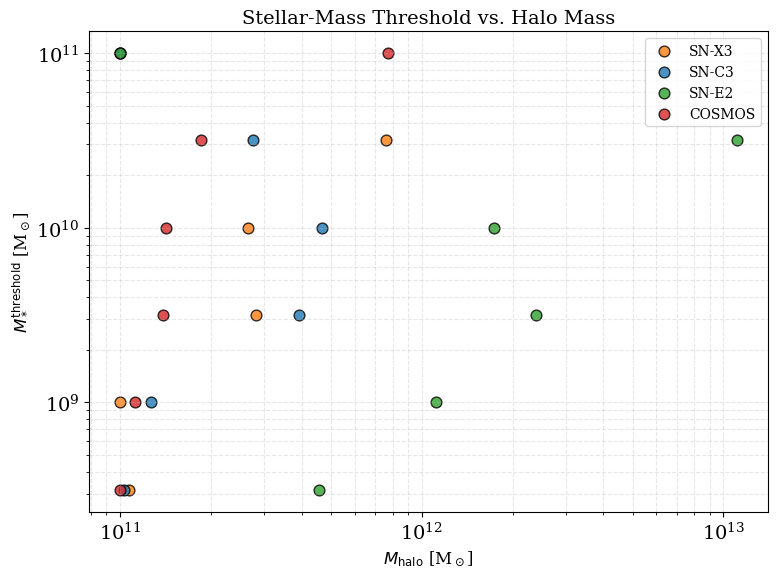

In [97]:

plt.figure(figsize=(8,6))
for field in fields.keys():
    x_vals = halo_by_field[field]
    y_vals = sm_by_field[field]
    plt.scatter(
        x_vals,
        y_vals,
        color=colors[field],
        label=field,
        s=60,
        edgecolors='k',
        alpha=0.8
    )

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$M_\mathrm{halo}$ [M$_\odot$]', fontsize=12)

plt.ylabel(r'$M_*^\mathrm{threshold}$ [M$_\odot$]', fontsize=12)
plt.title('Stellar‐Mass Threshold vs. Halo Mass', fontsize=14)
plt.legend(frameon=True, fontsize=10)
plt.grid(which='both', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('SHMR')
plt.show()


# Combine data and fit simultanously

In [9]:
class MultiFieldHODFitter:
    def __init__(self, selections):
        self.selections = selections
        
        theta0 = selections[0].theta
        for sel in selections:
            assert np.allclose(sel.theta, theta0), "All selections must share the same theta grid"

        self.theta = theta0
        self.mask = (self.theta >= 0.004) & (self.theta <= 0.4)

    def _combined_model(self, theta, logM_min, logM_1, alpha):
        model_vals = []
        for sel in self.selections:
            model = sel.hod_model(logM_min * 1e7, logM_1, alpha)[self.mask]
            model_vals.append(model)
        return np.concatenate(model_vals)

    def _combined_data(self):
        w_obs_all = []
        w_err_all = []

        for sel in self.selections:
            w = sel.w_theta[self.mask]
            err = np.sqrt(sel.var_w_theta_bootstrap[self.mask])
            w_obs_all.append(w)
            w_err_all.append(err)

        return np.concatenate(w_obs_all), np.concatenate(w_err_all)

    def fit(self, p0=None, bounds=None):
        if p0 is None:
            p0 = [12.3 * 1e-7, 13.5, 1.0]
        if bounds is None:
            bounds = ([11.0 * 1e-7, 12.5, 0.3], 
                      [14.5 * 1e-7, 15.5, 2.0])

        w_obs, w_err = self._combined_data()

        popt, pcov = curve_fit(
            self._combined_model,
            self.theta[self.mask],
            w_obs,
            sigma=w_err,
            p0=p0,
            bounds=bounds,
            maxfev=20000
        )

        for sel in self.selections:
            sel.hod_params = popt
            sel.xi_g = sel.hod_model(popt[0] * 1e7, popt[1], popt[2])

        return popt, pcov


In [10]:
def plot_joint_fit(field_selections, colors, SM_min, SM_max, shared_theta):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [2.5, 1]})

    for sel in field_selections:
        #field = sel.info.get('field_name', {field})
        field = sel.info.get('field_name', 'unknown')

        theta = sel.theta
        mask = (theta >= 0.004) & (theta <= 0.4)
        color = colors.get(field, 'black')

        w_obs = sel.w_theta
        w_model = sel.xi_g
        err = np.sqrt(sel.var_w_theta_bootstrap)

        ax1.errorbar(theta, w_obs, yerr=err, fmt='o', label=f'{field} (data)', color=color)
        ax1.plot(theta, w_model, linestyle='--', color=color, label=f'{field} (model)')

        res = (w_obs - w_model) / err
        ax2.plot(theta[mask], res[mask], marker='o', color=color, label=field)

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel(r'$w(\theta)$', fontsize=14)
    ax1.set_title(f'Joint HOD Fit — log M* ∈ [{SM_min}, {SM_max}]', fontsize=15)
    ax1.legend()
    ax1.grid(True, which="both", ls="--", alpha=0.3)

    ax2.axhline(0, color='black', ls='--')
    ax2.axhline(1, color='gray', ls=':', alpha=0.5)
    ax2.axhline(-1, color='gray', ls=':', alpha=0.5)
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$\theta$ [deg]', fontsize=14)
    ax2.set_ylabel('Residuals', fontsize=12)
    ax2.grid(True, which="both", ls="--", alpha=0.3)

    plt.tight_layout()
    plt.show()




🔹 Processing stellar mass bin 8.5–12.5
The following patch numbers have no objects: {27}
This may be a problem depending on your use case.

🔸 Processing field: SN-X3

🔸 Processing field: SN-C3

🔸 Processing field: SN-E2

🔸 Processing field: COSMOS

✅ Joint HOD best-fit: logM_min = 11.52, logM_1 = 13.00, alpha = 1.01


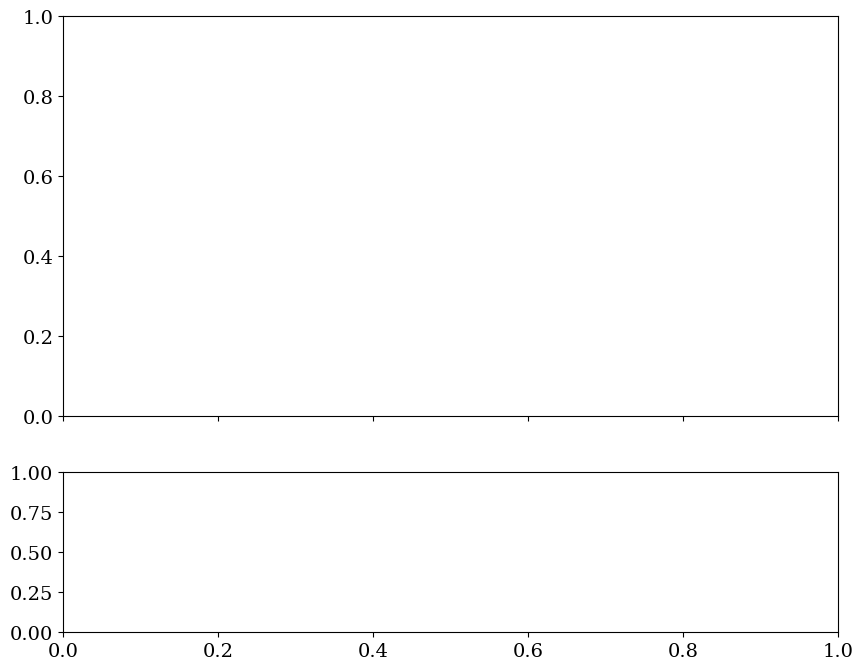

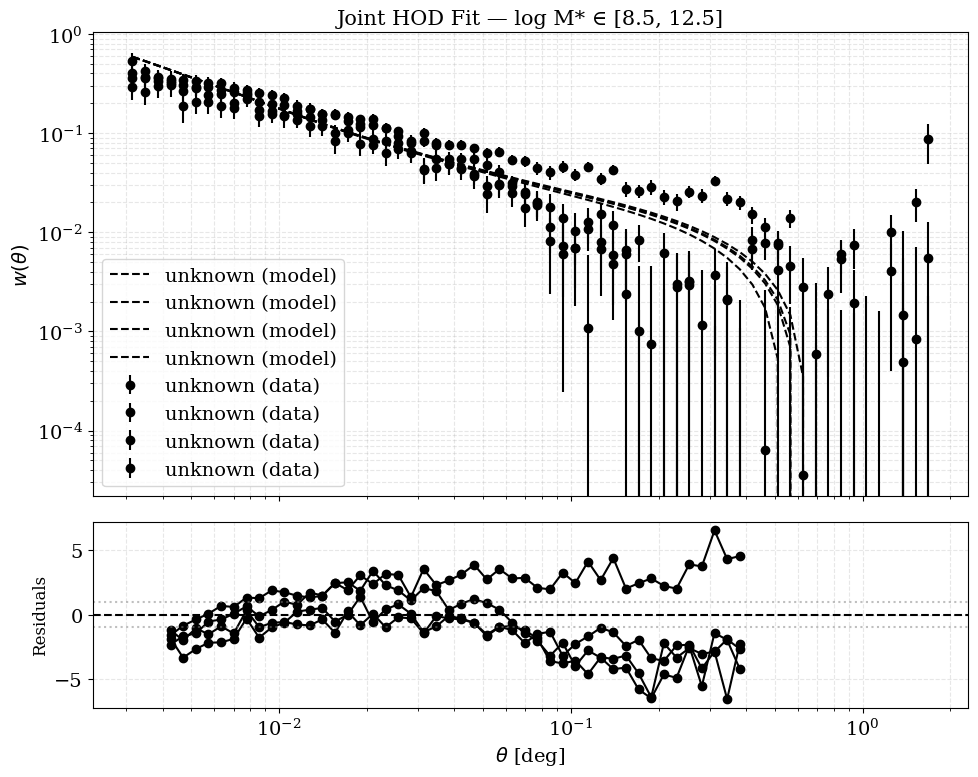



🔹 Processing stellar mass bin 9.5–12.5

🔸 Processing field: SN-X3

🔸 Processing field: SN-C3

🔸 Processing field: SN-E2

🔸 Processing field: COSMOS

✅ Joint HOD best-fit: logM_min = 11.72, logM_1 = 13.00, alpha = 1.01


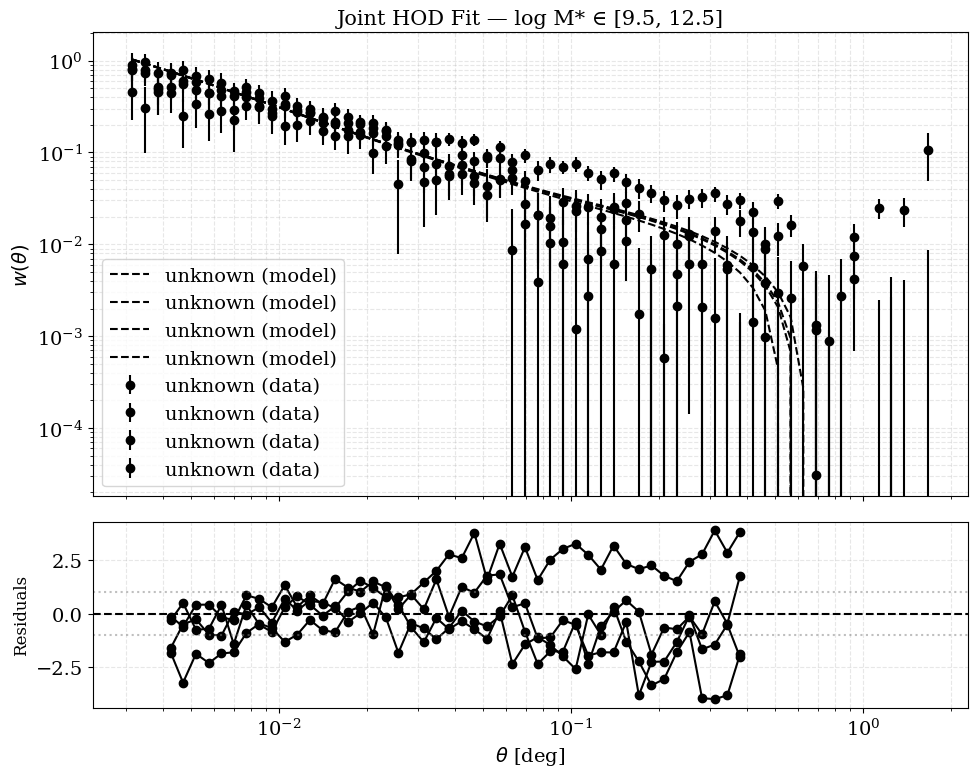



🔹 Processing stellar mass bin 10.5–12.5

🔸 Processing field: SN-X3

🔸 Processing field: SN-C3
The following patch numbers have no objects: {46}
This may be a problem depending on your use case.

🔸 Processing field: SN-E2

🔸 Processing field: COSMOS

✅ Joint HOD best-fit: logM_min = 12.64, logM_1 = 14.34, alpha = 1.01


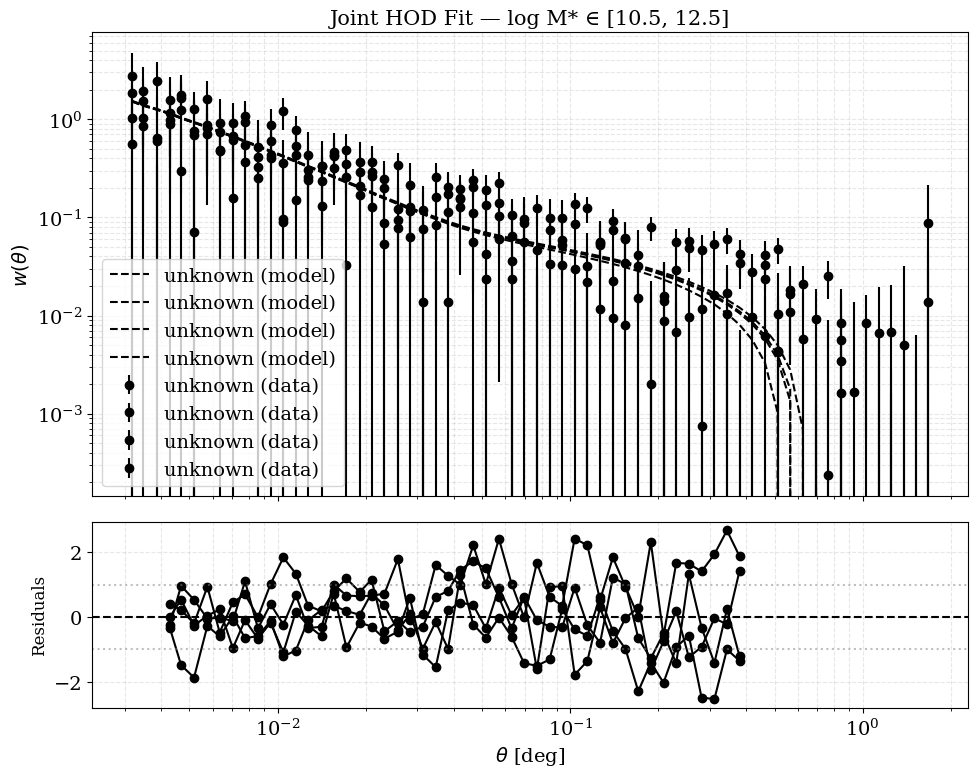

In [11]:
from astropy.table import Table, join
from scipy.interpolate import interp1d
import os
import numpy as np

# Configuration
config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

z_min, z_max = 0.2, 0.5
SM_bins = [(8.5, 12.5), (9.5,12.5), (10.5, 12.5)]


home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

#fields = {
 #   "SN-X3": {"catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits", "masked":  "SN-X3_masked_cat.fits", "randoms":"SN-X3_randoms_ugriz_trim_video.fits"},
  #  "SN-C3": {"catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits", "masked":  "SN-C3_masked_cat.fits", "randoms":"SN-C3_randoms_ugriz_trim_video.fits"},
 #   "SN-E2": {"catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits", "masked":  "SN-E2_masked_cat.fits", "randoms":"SN-E2_randoms_ugriz_trim_video.fits"},
 #   "COSMOS": {"catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits", "masked":  "COSMOS_masked_cat.fits", "randoms":"COSMOS_randoms_ugriz_trim_video.fits"}
#}



## Use the SBI outputs!!!
fields = {
    "SN-X3": {
        "catalog": "DES_DF_SN-X3_sbi_output.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "DES_DF_SN-C3_sbi_output.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "DES_DF_SN-E2_sbi_output.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "DES_DF_COSMOS_sbi_output.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}


colors = {
    "SN-C3":  "tab:blue",
    "SN-X3":  "tab:orange",
    "COSMOS": "tab:red",
    "SN-E2":  "tab:green"
}

all_results = {sm_range: {} for sm_range in SM_bins}

# ⬇ Start SM bin loop
for SM_min, SM_max in SM_bins:
    print(f"\n\n🔹 Processing stellar mass bin {SM_min}–{SM_max}")

    # Use first field to define shared theta grid
    first_field = list(fields.keys())[0]
    fpaths = fields[first_field]
    fcat = Table.read(os.path.join(thesis_path, fpaths["catalog"]))
    fmask = Table.read(os.path.join(thesis_path, fpaths["masked"]))
    fcat = join(fcat, fmask, keys='id')
    #fcat.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    fcat.rename_column('mode_z','z')
    fcat.rename_column('mode_mass','SM')
    frand = Table.read(os.path.join(thesis_path, fpaths["randoms"]))
    first_sub = dv.Selection(fcat, frand, z_min, z_max, SM_min, SM_max, config)
    shared_theta = np.array(first_sub.theta)  # Reference grid

    # Prepare field-wise results
    field_selections = []
    bias_eff_dict = {}
    sm_by_field, halo_by_field = {}, {}

    # ⬇️ Loop over all fields
    for field, paths in fields.items():
        print(f"\n🔸 Processing field: {field}")
        cat = Table.read(os.path.join(thesis_path, paths["catalog"]))
        mask = Table.read(os.path.join(thesis_path, paths["masked"]))
        cat = join(cat, mask, keys='id')
        #cat.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        cat.rename_column('mode_z','z')
        cat.rename_column('mode_mass','SM')
        rand = Table.read(os.path.join(thesis_path, paths["randoms"]))

        sub = dv.Selection(cat, rand, z_min, z_max, SM_min, SM_max, config)

        # 🔁 Force consistent theta + interpolate everything
        interp_w = interp1d(sub.theta, sub.w_theta, kind='linear', bounds_error=False, fill_value="extrapolate")
        interp_var = interp1d(sub.theta, sub.var_w_theta_bootstrap, kind='linear', bounds_error=False, fill_value="extrapolate")
        sub.w_theta = interp_w(shared_theta)
        sub.var_w_theta_bootstrap = interp_var(shared_theta)
        sub.theta = shared_theta

        field_selections.append(sub)
        bias_eff_dict[field] = sub.gg.bias_effective_tracer

    # ⬇️ Joint HOD fit using MultiFieldHODFitter
    fitter = MultiFieldHODFitter(field_selections)
    #hod_params, pcov = fitter.fit(p0=[12.3e-7, 13.5, 1.0])  # example init
    hod_params, pcov = fitter.fit(p0=[12.59*1e-7, 13.97, 1.], bounds=([11.0*1e-7, 13., 0.99], [14.5*1e-7, 15.5, 1.01])) # Fix alpha to 1

    logM_min, logM_1, alpha = hod_params
    print(f"\n✅ Joint HOD best-fit: logM_min = {logM_min*1e7:.2f}, logM_1 = {logM_1:.2f}, alpha = {alpha:.2f}")

    all_results[(SM_min, SM_max)] = {
        'field_selections': field_selections,
        'hod_params': hod_params,
        'pcov': pcov,
        'bias_eff': bias_eff_dict
    }

    plot_joint_fit(field_selections, colors, SM_min, SM_max, shared_theta)


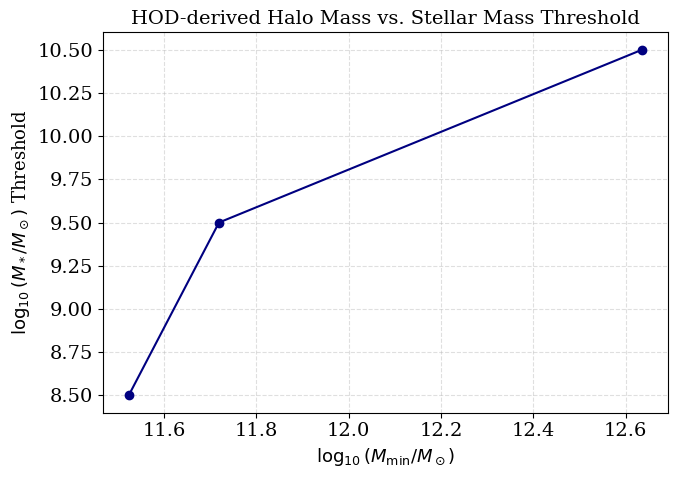

In [12]:

sm_thresholds = []
mmin_values = []

for (SM_min, SM_max), result in all_results.items():
    if result.get('hod_params') is None:
        continue  # Skip if fit failed

    logM_min = result['hod_params'][0]  # This is logM_min * 1e-7
    logM_min = logM_min * 1e7

    sm_thresholds.append(SM_min)
    mmin_values.append(logM_min)

plt.figure(figsize=(7, 5))
plt.plot( mmin_values,sm_thresholds, marker='o', linestyle='-', color='navy')


plt.ylabel(r'$\log_{10}(M_*/M_\odot)$ Threshold', fontsize=13)
plt.xlabel(r'$\log_{10}(M_{\mathrm{min}}/M_\odot)$', fontsize=13)
plt.title('HOD-derived Halo Mass vs. Stellar Mass Threshold', fontsize=14)
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()


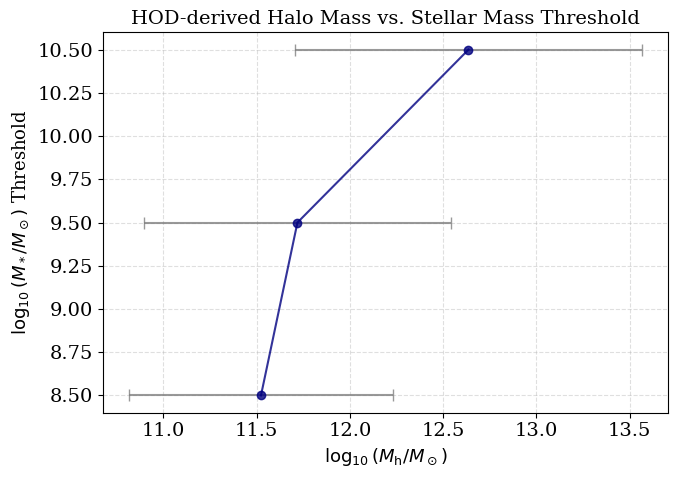

In [25]:

sm_thresholds = []
mmin_values = []
mmin_errs = []

for (SM_min, SM_max), result in all_results.items():
    if result.get('hod_params') is None or result.get('pcov') is None:
        continue  # Skip if missing fits

    logM_min = result['hod_params'][0]     
    logM_min = logM_min * 1e7

    
    # Extract error on logM_min from covariance matrix
    pcov = result['pcov']
    logM_min_err = np.sqrt(pcov[1, 1]) if pcov is not None else 0

    sm_thresholds.append(SM_min)
    mmin_values.append(logM_min)
    mmin_errs.append(logM_min_err)

plt.figure(figsize=(7, 5))

plt.errorbar(mmin_values, sm_thresholds,xerr=mmin_errs,fmt='o-', color='navy', ecolor='gray', capsize=4, capthick=1, alpha=0.8
)
plt.xlabel(r'$\log_{10}(M_{\mathrm{h}}/M_\odot)$', fontsize=13)
plt.ylabel(r'$\log_{10}(M_*/M_\odot)$ Threshold', fontsize=13)

plt.title('HOD-derived Halo Mass vs. Stellar Mass Threshold', fontsize=14)
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.savefig("Mh_vs_SM")

plt.show()


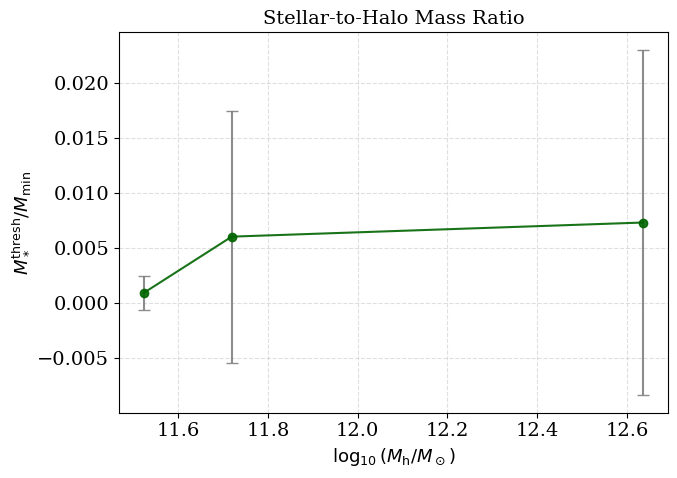

In [27]:
sm_thresholds = []
shmr_values = []
shmr_errs = []
mmin_values = []
mmin_errs = []

for (SM_min, SM_max), result in all_results.items():
    if result.get('hod_params') is None or result.get('pcov') is None:
        continue  # Skip if missing fits

    logM_min = result['hod_params'][0] 
    logM_min = logM_min * 1e7
    pcov = result['pcov']
    
    # Compute SHMR
    shmr = 10**(SM_min - logM_min)
    
    # Extract error on logM_min from covariance matrix (index 0,0)
    logM_min_err = np.sqrt(pcov[1, 1]) if pcov is not None else 0
    
    # Propagate error to SHMR
    shmr_err = shmr * logM_min_err * np.log(10)
    
    sm_thresholds.append(SM_min)
    mmin_values.append(logM_min)
    mmin_errs.append(logM_min_err)
    shmr_values.append(shmr)
    shmr_errs.append(shmr_err)
plt.figure(figsize=(7, 5))

plt.errorbar(mmin_values, shmr_values, yerr=shmr_errs, fmt='o-', color='darkgreen',
             ecolor='gray', capsize=4, capthick=1, alpha=0.9)

plt.xlabel(r'$\log_{10}(M_{\mathrm{h}}/M_\odot)$', fontsize=13)
plt.ylabel(r'$M_*^{\mathrm{thresh}} / M_{\mathrm{min}}$', fontsize=13)
plt.title('Stellar-to-Halo Mass Ratio', fontsize=14)
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.savefig("Mh_vs_SMHR")

plt.show()


# Compare over/under-abundance of objects with clustering strength (effective bias).

In [37]:
def compute_cosmic_variance(field_bias_estimator, global_bias):
    """
    Compute cosmic variance (δ_b and δ_DM) for each field.

    Parameters:
    - field_bias_estimator: instance of FieldBiasEstimator (with fields already added)
    - global_bias: float, global bias from combined fit

    Returns:
    - Dictionary with field-wise cosmic variance info
    """
    cosmic_var_results = {}
    individual_results = field_bias_estimator.fit_individual_fields()

    for name, bias, bias_err, IC in individual_results:
        if np.isnan(bias):
            cosmic_var_results[name] = None
            continue
        f = bias / global_bias
        delta_b = (21. / 68.) * np.log(f)
        delta_dm = delta_b / global_bias

        cosmic_var_results[name] = {
            'bias': bias,
            'bias_err': bias_err,
            'f': f,
            'delta_b': delta_b,
            'delta_dm': delta_dm,
            'IC': IC
        }

        print(f"    → {name}: f = {f:.3f}, δ_b = {delta_b:.4f}, δ_DM = {delta_dm:.4f}")

    return cosmic_var_results



In [117]:


home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked":  "SN-X3_masked_cat.fits",
        "randoms":"SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked":  "SN-C3_masked_cat.fits",
        "randoms":"SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked":  "SN-E2_masked_cat.fits",
        "randoms":"SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked":  "COSMOS_masked_cat.fits",
        "randoms":"COSMOS_randoms_ugriz_trim_video.fits"
    }
}

colors = {
    "SN-C3":  "tab:blue",
    "SN-X3":  "tab:orange",
    "COSMOS": "tab:red",
    "SN-E2":  "tab:green"
}

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

# Fixed stellar mass bin
SM_min, SM_max =  10.0, 12.5  # example fixed stellar mass range

# Redshift bins from 0 to 1 with bin width 0.2
z_bins = [(i, i+0.2) for i in np.arange(0, 1, 0.2)]

sm_by_field   = {field: [] for field in fields.keys()}
halo_by_field = {field: [] for field in fields.keys()}

all_results = {z_range: {} for z_range in z_bins}

for z_min, z_max in z_bins:
    print(f"\n\n🔹 Processing redshift bin {z_min:.2f}–{z_max:.2f} with stellar mass {SM_min}–{SM_max}")
    
    # Initialize bias estimator using first field
    first_field = list(fields.keys())[0]
    first_paths = fields[first_field]
    first_catalog = Table.read(os.path.join(thesis_path, first_paths["catalog"]))
    first_masked = Table.read(os.path.join(thesis_path, first_paths["masked"]))
    first_catalog = join(first_catalog, first_masked, keys='id')
    first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    first_randoms = Table.read(os.path.join(thesis_path, first_paths["randoms"]))
    
    first_subsample = dv.Selection(
        catalog=first_catalog,
        randoms=first_randoms,
        z_min=z_min,
        z_max=z_max,
        SM_min=SM_min,
        SM_max=SM_max,
        config=config
    )
    first_results = first_subsample.get_results()
    
    estimator = dv.FieldBiasEstimator(
        xi_m=np.array(first_results['xi_m']),
        mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
    )
    
    bias_eff_dict = {}

    for field, paths in fields.items():
        print(f"\n🔸 Processing field: {field}")
        
        catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
        masked  = Table.read(os.path.join(thesis_path, paths["masked"]))
        catalog = join(catalog, masked, keys='id')
        catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))
        
        subsample = dv.Selection(
            catalog=catalog,
            randoms=randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )
        
        hod_params, pcov = subsample.fit_hod(p0=[12.59*1e-7, 13.97, 1.], bounds=([11.0*1e-7, 13., 0.99], [14.5*1e-7, 15.5, 1.01]))

        results = subsample.get_results()
        
        logM_min, logM_1, alpha = results['hod_params']
        logM_halo = logM_min * 1e7
        M_halo = 10**(logM_halo)
        M_SM = 10**(SM_min)
        
        sm_by_field[field].append(M_SM)
        halo_by_field[field].append(M_halo)
        
        print(f"    → HOD fit (field={field}):  M_halo = 10^{logM_halo:.2f} ")
        
        xi_g = np.array(results['xi_g'])
        wth = np.array(results['w_theta'])
        wth_err = np.sqrt(np.array(results['var_w_theta_bootstrap']))
        rr_counts = np.array(results['rr_counts'])
        
        estimator.add_field(
            field_name=field,
            xi_g=xi_g,
            w_theta=wth,
            w_theta_error=wth_err,
            sum_rr=rr_counts
        )
        
        bias_eff = subsample.gg.bias_effective_tracer
        bias_eff_dict[field] = bias_eff
        print(f"    → bias_eff = {bias_eff:.3f}")
        
    individual_results = estimator.fit_individual_fields()
    global_b, global_be = estimator.fit_combined()
    
    print(f"    • Global bias estimate: {global_b:.3f} ± {global_be:.3f}")
    for name, b, be, ic in individual_results:
        print(f"    • {name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")
    
    cosmic_var = compute_cosmic_variance(estimator, global_b)
    
    all_results[(z_min, z_max)] = {
        'individual': individual_results,
        'global_b': global_b,
        'global_be': global_be,
        'cosmic_var': cosmic_var,
        'estimator': estimator,
        'bias_eff': bias_eff_dict,
        'logM_min': logM_min
    }



🔹 Processing redshift bin 0.00–0.20 with stellar mass 10.0–12.5
The following patch numbers have no objects: {1, 33, 35, 5, 41, 10, 44, 13, 18, 19, 27, 29, 30, 31}
This may be a problem depending on your use case.
The following patch numbers have no objects: {1, 33, 35, 7, 40, 9, 42, 44, 46, 15, 49, 21, 23, 25, 27, 28}
This may be a problem depending on your use case.
The following patch numbers have no objects: {0, 2, 6, 40, 10, 42, 12, 44, 15, 16, 49, 19, 23, 25, 27, 29}
This may be a problem depending on your use case.
The following patch numbers have no objects: {1, 34, 3, 5, 7, 9, 11, 45, 14, 47, 49, 19, 25}
This may be a problem depending on your use case.
The following patch numbers have no objects: {2, 37, 6, 40, 42, 11, 12, 14, 47, 49, 20, 22}
This may be a problem depending on your use case.
The following patch numbers have no objects: {1, 34, 3, 7, 39, 10, 12, 16, 49, 19, 22, 24, 26, 28, 29}
This may be a problem depending on your use case.
The following patch numbers have

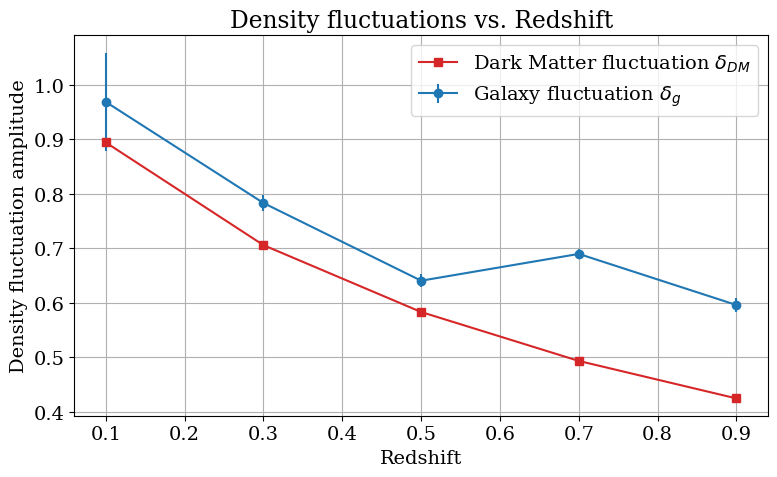

In [119]:

# Example redshift bin centers
z_centers = [0.1, 0.3, 0.5, 0.7, 0.9]

# Prepare arrays to store results per redshift bin
global_biases = []
global_bias_errors = []

# For δ_DM: estimate from xi_m, e.g. at some fixed theta index
delta_dm_vals = []

# For δ_b: use global bias * delta_dm (simplified)
delta_b_vals = []

for z_bin in all_results.keys():
    res = all_results[z_bin]
    estimator = res['estimator']
    global_b = res['global_b']
    global_be = res['global_be']
    global_biases.append(global_b)
    global_bias_errors.append(global_be)
    
    # Extract xi_m (dark matter correlation) and pick a scale index
    xi_m = estimator.xi_m  
    scale_index = 5  # pick appropriate index or mean over range
    
    delta_dm = np.sqrt(xi_m[scale_index]) if xi_m[scale_index] > 0 else 0
    delta_dm_vals.append(delta_dm)
    
    # δ_b = bias * δ_DM
    delta_b_vals.append(global_b * delta_dm)

# Convert z_bins to centers for plotting
z_plot = [0.5*(z[0] + z[1]) for z in all_results.keys()]

plt.figure(figsize=(8,5))
plt.errorbar(z_plot, delta_b_vals, yerr=np.array(global_bias_errors)*np.array(delta_dm_vals),
             label=r'Galaxy fluctuation $\delta_g$', color='tab:blue', marker='o')
plt.plot(z_plot, delta_dm_vals, label=r'Dark Matter fluctuation $\delta_{DM}$', color='tab:red', marker='s')

plt.xlabel('Redshift')
plt.ylabel('Density fluctuation amplitude')
plt.title('Density fluctuations vs. Redshift')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Shuntov data  $z \in [0.2, 0.5]$

In [29]:
shuntov_data = {
    (10.5, 12.5): {
        "theta": np.array([
            8.6213e-04, 1.8266e-03, 3.8500e-03, 8.4446e-03,
            1.9095e-02, 4.1869e-02, 9.3389e-02, 2.0352e-01,
            4.3985e-01, 8.6697e-01
        ]),
        "wtheta": np.array([
            4.0512, 2.1335, 0.76826, 0.60844,
            0.23972, 0.064465, 0.021901, 0.0086372,
            0.0026260, -0.0046342
        ]),
        "error": np.array([
            1.4703, 0.58440, 0.19946, 0.11059,
            0.10579, 0.051982, 0.018514, 0.012101,
            0.0047944, 0.0036775
        ])
    },
    (9.6, 10.5): {
        "theta": np.array([
            8.6177e-04, 1.8088e-03, 3.9387e-03, 8.6512e-03,
            1.9151e-02, 4.2155e-02, 9.3135e-02, 2.0382e-01,
            4.4044e-01, 8.6983e-01
        ]),
        "wtheta": np.array([
            2.4589, 1.4099, 0.66725, 0.40769,
            0.18806, 0.072816, 0.011834, 0.0077454,
            0.0029769, -0.0041483
        ]),
        "error": np.array([
            0.35086, 0.11457, 0.070194, 0.052862,
            0.046929, 0.022189, 0.0089981, 0.0070251,
            0.0029207, 0.0022315
        ])
    },
    (9.0, 9.6): {
        "theta": np.array([
            8.3259e-04, 1.8063e-03, 3.9674e-03, 8.7145e-03,
            1.9194e-02, 4.2263e-02, 9.3085e-02, 2.0379e-01,
            4.4007e-01, 8.6861e-01
        ]),
        "wtheta": np.array([
            1.2910, 0.97706, 0.52575, 0.33105,
            0.15498, 0.061639, 0.012956, 0.0081038,
            0.0026256, -0.0043871
        ]),
        "error": np.array([
            0.16438, 0.080514, 0.037668, 0.037046,
            0.029617, 0.016203, 0.0084722, 0.0077168,
            0.0032781, 0.0026839
        ])
    },
    (8.6, 9.0): {
        "theta": np.array([
            8.4966e-04, 1.8031e-03, 3.9695e-03, 8.7495e-03,
            1.9216e-02, 4.2306e-02, 9.3108e-02, 2.0376e-01,
            4.4003e-01, 8.6822e-01
        ]),
        "wtheta": np.array([
            0.86374, 0.76856, 0.43005, 0.26244,
            0.13492, 0.050636, 0.012632, 0.0066597,
            0.0023886, -0.0037334
        ]),
        "error": np.array([
            0.098497, 0.043001, 0.033822, 0.023979,
            0.019220, 0.011188, 0.0070628, 0.0067357,
            0.0029484, 0.0024237
        ])
    },
    (8.17, 8.6): {
        "theta": np.array([
            8.4620e-04, 1.8016e-03, 3.9815e-03, 8.7588e-03,
            1.9257e-02, 4.2327e-02, 9.3100e-02, 2.0381e-01,
            4.4014e-01, 8.6768e-01
        ]),
        "wtheta": np.array([
            0.60852, 0.56341, 0.32357, 0.19411,
            0.10953, 0.040942, 0.012872, 0.0058622,
            0.0021337, -0.0033312
        ]),
        "error": np.array([
            0.057764, 0.029369, 0.022334, 0.019434,
            0.014293, 0.0085523, 0.0054175, 0.0060078,
            0.0021963, 0.0020317
        ])
    }
}


In [ ]:
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78, 
    'nbins': 10,
    #'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}


for (SM_min, SM_max), result in all_results.items():

    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))

    # Retrieve Shuntov data
    shuntov = shuntov_data[(SM_min, SM_max)]
    shuntov_theta = shuntov["theta"]
    shuntov_wtheta = shuntov["wtheta"]
    shuntov_error = shuntov["error"]

    # Plot COSMOS measurements
    for field_data in estimator.fields:
        #if field_data['name'] != 'COSMOS':
            #continue

        results = subsample.get_results()
        theta = results['theta']

        #theta = shuntov_theta  # Use same θ as Shuntov
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']

        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o', color='blue', label='This work', capsize=3)

        # HOD fitting for this stellar mass bin
        sub = dv.Selection( catalog, randoms, z_min=0.2, z_max=0.5, SM_min=SM_min, SM_max=SM_max, config=config)
        hod_params, pcov = sub.fit_hod() # p0=[12.5, 13.5, 1.0], bounds=([12.0, 13.0, 0.5], [13.0, 14.0, 1.5])

        results = sub.get_results()
        
        bias_eff = sub.gg.bias_effective_tracer
        bias_eff_dict[field] = bias_eff
        print(f"  ➤ bias_eff = {bias_eff:.3f}")
        
        logM_min, logM_1, alpha = results['hod_params']
        print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
              f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")
        w_model = subsample.hod_model(logM_min *1e7, logM_1, alpha) 
        

        xi_m_values = sub.get_results()['xi_m']

        ax.plot(theta, w_model, label='Best-fit HOD Model', color='red')
        # ax.plot(theta, xi_m_values, label=r'$\omega_{dm}(\theta)$ (Matter)', linestyle='dashed', color='black')

    # Plot Shuntov+2022 data
    ax.errorbar(shuntov_theta, shuntov_wtheta, yerr=shuntov_error, fmt='s', color='black', label='Shuntov+2022', capsize=3)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_*$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.set_ylim([1e-4, 10])
    ax.legend(fontsize=10, framealpha=0.8)
    ax.grid(True, which="both", ls="--", alpha=0.3)

    # Optional annotations
    ax.text(0.2, 0.9, "1-halo region", transform=ax.transAxes, color='gray')
    ax.text(0.6, 0.9, "2-halo region", transform=ax.transAxes, color='gray')

    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_vs_Shuntov_HOD_SM_{SM_min}_{SM_max}.png")
    plt.show()


# SHMR 



🔹 Processing stellar mass bin 8.6–9

🔸 Processing field: COSMOS
HOD fit results: M_min = 10^11.00, M_1 = 10^12.92, alpha = 0.89
  ➤ bias_eff = 0.892


🔹 Processing stellar mass bin 9–10

🔸 Processing field: COSMOS
HOD fit results: M_min = 10^11.07, M_1 = 10^12.67, alpha = 1.12
  ➤ bias_eff = 1.019


🔹 Processing stellar mass bin 10–11

🔸 Processing field: COSMOS
HOD fit results: M_min = 10^11.01, M_1 = 10^12.57, alpha = 1.03
  ➤ bias_eff = 0.991


🔹 Processing stellar mass bin 11–12.5

🔸 Processing field: COSMOS
The following patch numbers have no objects: {4}
This may be a problem depending on your use case.
The following patch numbers have no objects: {5}
This may be a problem depending on your use case.
The following patch numbers have no objects: {12}
This may be a problem depending on your use case.
The following patch numbers have no objects: {38}
This may be a problem depending on your use case.
The following patch numbers have no objects: {28}
This may be a problem depending 

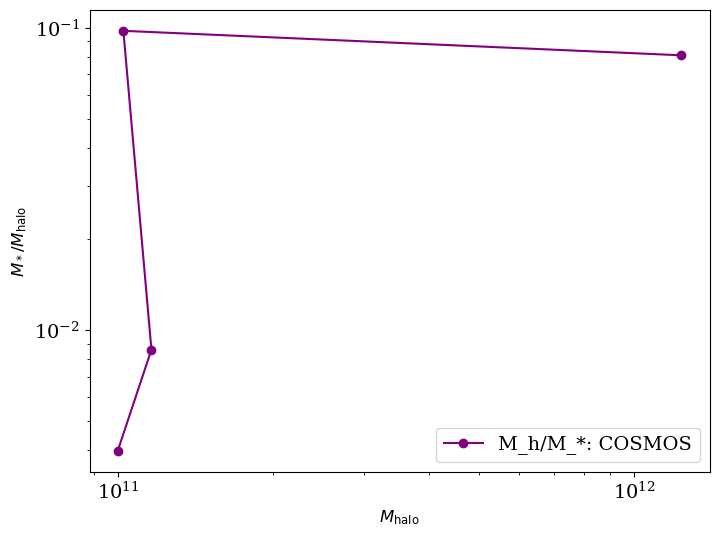

In [34]:

stellar_masses = []
halo_masses = []
shmr_values = []

selected_field = "COSMOS"

for (SM_min, SM_max), result in all_results.items():
    print(f"\n\n🔹 Processing stellar mass bin {SM_min}–{SM_max}")

    # Only process the selected field
    paths = fields[selected_field]
    print(f"\n🔸 Processing field: {selected_field}")

    # Perform HOD fitting
    sub = dv.Selection(catalog, randoms, z_min=0.2, z_max=0.5, SM_min=SM_min, SM_max=SM_max, config=config)
    hod_params, pcov = sub.fit_hod()
    results = sub.get_results()

    # Extract HOD parameters
    logM_min, logM_1, alpha = results['hod_params']
    print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

    bias_eff = sub.gg.bias_effective_tracer
    print(f"  ➤ bias_eff = {bias_eff:.3f}")
    
    # Compute SHMR
    logM_star = SM_min
    logM_halo = logM_min*1e7

    M_star = 10**logM_star
    M_halo = 10**logM_halo
    SHMR = M_star / M_halo

    stellar_masses.append(M_star)
    halo_masses.append(M_halo)
    shmr_values.append(SHMR)


# Plot SHMR vs Halo Mass
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(halo_masses, shmr_values, marker='o', linestyle='-', color='purple', label=f'M_h/M_*: {selected_field}')


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{\rm halo}$', fontsize=12)
ax.set_ylabel(r'$M_*/M_{\rm halo}$', fontsize=12)
ax.legend()

#plt.savefig(f"SHMR_vs_HaloMass_{selected_field}.png")
plt.show()


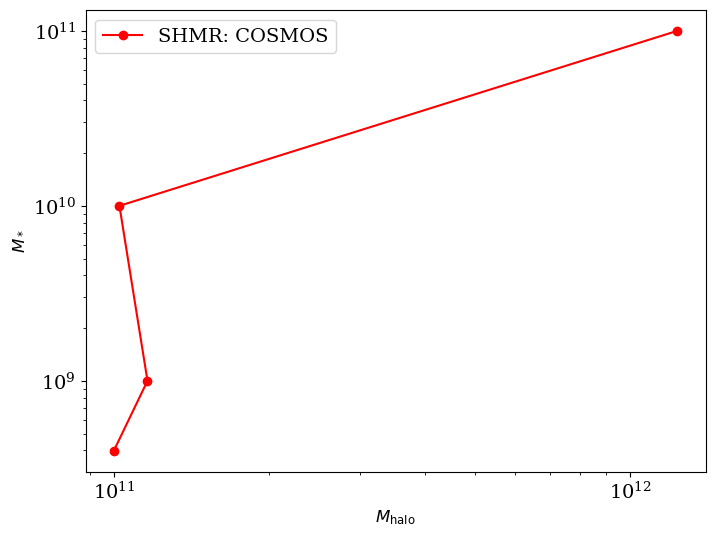

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(halo_masses, stellar_masses, marker='o', linestyle='-', color='red', label=f'SHMR: {selected_field}')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{\rm halo}$', fontsize=12)
ax.set_ylabel(r'$M_*$', fontsize=12)
ax.legend()

#plt.savefig(f"SHMR_vs_HaloMass_{selected_field}.png")
plt.show()


In [ ]:
for (SM_min, SM_max), result in all_results.items():
    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for field_data in estimator.fields:
        #theta = first_results['theta']
        results = subsample.get_results()
        theta = results['theta']
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']
        
        #ax.scatter(theta, w_theta, label=field_data['name'])
        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o--', label=field_data['name'], capsize=3)
            # Overlay Shuntov+2022 data
    ax.errorbar(
        shuntov_theta, shuntov_wtheta, yerr=shuntov_wtheta_err,
        fmt='s-', color='black', capsize=3, label='Shuntov+2022 '
    )

    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.legend()
    #ax.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"wtheta_SM_{SM_min}_{SM_max}.png")
    plt.show()


In [ ]:
for (SM_min, SM_max), result in all_results.items():
    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue  # Skip non-COSMOS fields

        results = subsample.get_results()
        theta = results['theta']        
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']
        
        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o', label='This work', capsize=3)
        #ax.scatter(theta, w_theta, label='This work')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ [COSMOS only] for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_SM_{SM_min}_{SM_max}.png")
    plt.show()


In [ ]:

shuntov_theta = np.array([
    8.6213e-04, 1.8266e-03, 3.8500e-03, 8.4446e-03, 1.9095e-02,
    4.1869e-02, 9.3389e-02, 2.0352e-01, 4.3985e-01, 8.6697e-01
])

shuntov_wtheta = np.array([
    4.0512, 2.1335, 0.76826, 0.60844, 0.23972,
    0.064465, 0.021901, 0.0086372, 0.002626, -0.0046342
])

shuntov_wtheta_err = np.array([
    1.4703, 0.5844, 0.19946, 0.11059, 0.10579,
    0.051982, 0.018514, 0.012101, 0.0047944, 0.0036775
])

#theta = np.exp(dd.meanlogr)




In [ ]:
for (SM_min, SM_max), result in all_results.items():
    if SM_min < 10.5:
        continue  # only plot for log(M*) > 10.5 bin

    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))

    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue

        results = subsample.get_results()
        theta = results['theta']
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']

        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o', label='This work', capsize=3)

    # Overlay Shuntov+2022 data
    ax.errorbar(
        shuntov_theta, shuntov_wtheta, yerr=shuntov_wtheta_err,
        fmt='s', color='black', capsize=3, label='Shuntov+2022 '
    )

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_*$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.legend()
    #ax.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_vs_Shuntov_SM_{SM_min}_{SM_max}.png")
    plt.show()


In [ ]:
for (SM_min, SM_max), result in all_results.items():
    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot my data
    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue

       # theta = config['min_sep'] * (10 ** (np.arange(len(field_data['w_theta'])) * config['bin_size']))
        results = subsample.get_results()
        theta = results['theta']

        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']

        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o--', capsize=3,  label='COSMOS (this work)')

    # Plot Shuntov data 
    if (SM_min, SM_max) in shuntov_data:
        sd = shuntov_data[(SM_min, SM_max)]
        ax.errorbar(
            sd['theta'], sd['wtheta'], yerr=sd['error'],
            fmt='s--', color='black', capsize=3, label='Shuntov+2022'
        )

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.legend()
    #ax.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_vs_Shuntov_SM_{SM_min}_{SM_max}.png")
    plt.show()

## Shuntov+2022, $z \in [0.2, 0.5]$

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.plasma(np.linspace(0, 1, len(shuntov_data)))

for (mass_range, color) in zip(shuntov_data, colors):
    data = shuntov_data[mass_range]
    label = f"log(M*/M☉): {mass_range[0]}–{mass_range[1]}"
    ax.errorbar(data["theta"], data["wtheta"], yerr=data["error"],
                fmt='o', label=label, color=color, capsize=3)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("θ [deg]")
ax.set_ylabel("w(θ)")
ax.set_title("Angular Correlation Function from Shuntov+2022, $z \in [0.2, 0.5]$'")
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:

#1 degree sep in Mpc: 25.67767075127877



In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.plasma(np.linspace(0, 1, len(shuntov_data)))


for i, ((SM_min, SM_max), result) in enumerate(all_results.items()):
    estimator = result['estimator']
    color = colors[i]
    
    # Plot this work (COSMOS)
    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':  
            continue

        theta = results['theta'] 
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']
        
        label = f"This work: $10^{{{SM_min}}}$"
        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o--', color=color,
                    label=label, capsize=3)

    # Plot Shuntov+2022 data
    shuntov = shuntov_data[(SM_min, SM_max)]
    ax.errorbar(shuntov["theta"], shuntov["wtheta"], yerr=shuntov["error"],fmt='s-', color=color, markerfacecolor='none', label=f"Shuntov+2022: $10^{{{SM_min}}}$", capsize=3)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
ax.set_ylabel(r'$w(\theta)$', fontsize=12)
ax.set_title(r'Angular Correlation Function $w(\theta)$ by Stellar Mass Bin', fontsize=14)
ax.legend(fontsize=8)
plt.tight_layout()
plt.savefig("wtheta_all_bins_comparison.png")
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.plasma(np.linspace(0, 1, len(shuntov_data)))


for i, ((SM_min, SM_max), result) in enumerate(all_results.items()):
    estimator = result['estimator']
    color = colors[i]
    
    # Plot this work (COSMOS)
    for field_data in estimator.fields:

        theta = results['theta'] 
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']
        
        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o--', color=color,
                    label=field_data['name'], capsize=3)

    # Plot Shuntov+2022 data
    shuntov = shuntov_data[(SM_min, SM_max)]
    ax.errorbar(shuntov["theta"], shuntov["wtheta"], yerr=shuntov["error"],fmt='s-', color=color, markerfacecolor='none', label=f"Shuntov+2022: $10^{{{SM_min}}}$", capsize=3)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
ax.set_ylabel(r'$w(\theta)$', fontsize=12)
ax.set_title(r'Angular Correlation Function $w(\theta)$ by Stellar Mass Bin', fontsize=14)
ax.legend(fontsize=8, framealpha=0.9)
plt.tight_layout()
plt.savefig("wtheta_all_fields_vs_shuntov.png")
plt.show()


# Shuntov data  in bins up to 1.1


In [60]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'nbins': 10,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

# Define bins
z_bins = [(0.2, 0.5), (0.5, 0.8), (0.8, 1.1)]
SM_bins = [(8.17, 8.6), (8.6, 9.0), (9.0, 9.6), (9.6, 10.5), (10.5, 12.5)]

# Storage for results
all_bins_results = {}

# Main loop
for z_min, z_max in z_bins:
    print(f"\n\n==========================")
    print(f"🔷 Redshift bin: {z_min}–{z_max}")
    print(f"==========================")
    
    all_bins_results[(z_min, z_max)] = {}

    for SM_min, SM_max in SM_bins:
        print(f"\n\n🔹 Stellar Mass bin: {SM_min}–{SM_max}")
        
        # Use first field as template
        first_field = list(fields.keys())[0]
        first_catalog = Table.read(os.path.join(thesis_path, fields[first_field]["catalog"]))
        first_masked = Table.read(os.path.join(thesis_path, fields[first_field]["masked"]))
        first_catalog = join(first_catalog, first_masked, keys='id')
        first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        first_randoms = Table.read(os.path.join(thesis_path, fields[first_field]["randoms"]))

        first_subsample = dv.Selection(
            catalog=first_catalog,
            randoms=first_randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )
        first_results = first_subsample.get_results()

        estimator = dv.FieldBiasEstimator(
            xi_m=np.array(first_results['xi_m']),
            mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
        )
        
        bias_eff_dict = {}

        for field, paths in fields.items():
            print(f"\n🔸 Field: {field}")
            
            catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
            masked = Table.read(os.path.join(thesis_path, paths["masked"]))
            catalog = join(catalog, masked, keys='id')
            catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
            randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))

            subsample = dv.Selection(
                catalog=catalog,
                randoms=randoms,
                z_min=z_min,
                z_max=z_max,
                SM_min=SM_min,
                SM_max=SM_max,
                config=config
            )

            hod_params, pcov = subsample.fit_hod()

            results = subsample.get_results()
            
            bias_eff = subsample.gg.bias_effective_tracer
            bias_eff_dict[field] = bias_eff
            print(f"  ➤ bias_eff = {bias_eff:.3f}")

            logM_min, logM_1, alpha = results['hod_params']
            print(f"HOD: M_min = 10^{logM_min*1e7:.2f}, M_1 = 10^{logM_1:.2f}, α = {alpha:.2f}")
            
            estimator.add_field(
                field_name=field,
                xi_g=np.array(results['xi_g']),
                w_theta=np.array(results['w_theta']),
                w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),
                sum_rr=np.array(results['rr_counts'])
            )

        print("\nIndividual Field Results:")
        individual_results = estimator.fit_individual_fields()
        for name, b, be, ic in individual_results:
            print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")

        global_b, global_be = estimator.fit_combined()
        print(f"\n Global bias: b = {global_b:.3f} ± {global_be:.3f}")

        # Store in nested dictionary
        all_bins_results[(z_min, z_max)][(SM_min, SM_max)] = {
            'individual': individual_results,
            'global_b': global_b,
            'global_be': global_be,
            'estimator': estimator,
            'bias_eff': bias_eff_dict
        }




🔷 Redshift bin: 0.2–0.5


🔹 Stellar Mass bin: 8.17–8.6

🔸 Field: SN-X3
  ➤ bias_eff = 0.839
HOD: M_min = 10^11.00, M_1 = 10^15.50, α = 0.40

🔸 Field: SN-C3
  ➤ bias_eff = 0.840
HOD: M_min = 10^11.00, M_1 = 10^15.50, α = 0.30

🔸 Field: SN-E2
  ➤ bias_eff = 0.836
HOD: M_min = 10^11.00, M_1 = 10^15.50, α = 2.00

🔸 Field: COSMOS
  ➤ bias_eff = 0.836
HOD: M_min = 10^11.00, M_1 = 10^15.50, α = 2.00

Individual Field Results:
SN-X3: b = 1.117 ± 0.085, IC = 0.0131
SN-C3: b = 1.122 ± 0.093, IC = 0.0124
SN-E2: b = 1.201 ± 0.085, IC = 0.0149
COSMOS: b = 1.253 ± 0.137, IC = 0.0184

 Global bias: b = 0.897 ± 0.065


🔹 Stellar Mass bin: 8.6–9.0

🔸 Field: SN-X3
  ➤ bias_eff = 0.854
HOD: M_min = 10^11.04, M_1 = 10^14.07, α = 0.31

🔸 Field: SN-C3
The following patch numbers have no objects: {28}
This may be a problem depending on your use case.
The following patch numbers have no objects: {29}
This may be a problem depending on your use case.
  ➤ bias_eff = 0.954
HOD: M_min = 10^11.02, M_1 = 10^13.33

KeyboardInterrupt: 